In [1]:
import numpy as np
import random
from bs4 import BeautifulSoup
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
import matplotlib.pyplot as plt
import networkx as nx
#from colour import Color
import copy
from collections import Counter

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv

import json

import seaborn as sns

np.random.seed(42)
random.seed(42)
import pm4py

from collections import Counter
import subprocess

from sklearn import mixture

from  matplotlib.colors import LinearSegmentedColormap # for color map
from matplotlib.colors import rgb2hex
import os # for output

In [2]:
PRISM_PATH = "/home/paul/Downloads/prism-games-3.1/prism/bin/prism"
STRATEGY_PATH = "/home/paul/Documents/probabilistic_games/adv.tra"

In [3]:
from pm4py.objects.log.importer.xes import importer as xes_importer
log_application = xes_importer.apply('data/BPI Challenge 2017.xes')

/home/paul/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:50<00:00, 627.09it/s]


In [4]:
# A_complete is always preceeded by "W_call after offers"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "A_Complete" in pos["concept:name"]:
            if "W_Call after offers" not in trace[pos_index-1]["concept:name"]:
                for e in trace[pos_index-5:pos_index+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [5]:
# "W_call after offers" has always "A_complete"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "W_call after offers" in pos["concept:name"]:
            index_inner = pos_index+1
            while trace[index_inner]["concept:name"] == "W_call after offers":
                index_inner += 1
            if "A_complete" not in trace[index_inner]["concept:name"]:
                for e in trace[index_inner-5:index_inner+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [6]:
# A_Incomplete is always surrounded by "W_Call incomplete files"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "A_Incomplete" in pos["concept:name"]:
            if "W_Call incomplete files" not in trace[pos_index-1]["concept:name"] and "W_Call incomplete files" not in trace[pos_index+1]["concept:name"]:
                for e in trace[pos_index-5:pos_index+5]:
                    print(e["concept:name"])
                print("not followed")
                assert(False)

In [7]:
#Create offer is always followed by "Created"
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "Create Offer" in pos["concept:name"]:
            if "Created" not in trace[pos_index+1]["concept:name"]:
                print("not followed")

In [8]:
# number of calls
for trace in log_application:
    for pos_index in range(len(trace)):
        pos = trace[pos_index]
        if "Create Offer" in pos["concept:name"]:
            if "Created" not in trace[pos_index+1]["concept:name"]:
                print("not followed")

In [9]:
def contains(trace, element):
    for event in trace:
        if event['concept:name']==element:
            return True

In [10]:
log = copy.deepcopy(log_application)
log_before = pm4py.filter_time_range(log, "2011-03-09 00:00:00", "2016-06-30 23:59:59", mode='traces_contained')
log_after = pm4py.filter_time_range(log, "2016-08-01 00:00:00", "2018-03-09 00:00:00", mode='traces_contained')
print(len(log))
print(len(log_before))
print(len(log_after))

31509
12207
14164


/home/paul/.local/lib/python3.10/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [11]:
def filter_log(log):
    perc = 2/len(log)
    return pm4py.filter_variants_by_coverage_percentage(log, perc)

filtered_log_before = filter_log(log_before)
filtered_log_after = filter_log(log_after)
print(len(filtered_log_before))
print(len(filtered_log_after))

6156
7636


6156 7636
10 12
{'Action': 'Obtained', 'org:resource': 'User_18', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_313669609', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 4, 11, 10, 49, 19, 466000, tzinfo=datetime.timezone.utc)}
{'Action': 'Released', 'org:resource': 'User_18', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_567241498', 'lifecycle:transition': 'suspend', 'time:timestamp': datetime.datetime(2016, 4, 11, 15, 11, 51, 55000, tzinfo=datetime.timezone.utc)}
[{'Action': 'Obtained', 'org:resource': 'User_18', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_313669609', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 4, 11, 10, 49, 19, 466000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_18', 'concept:name': 'A_Complete', 'EventOrigin': 'Application', 'EventID': 'ApplState_

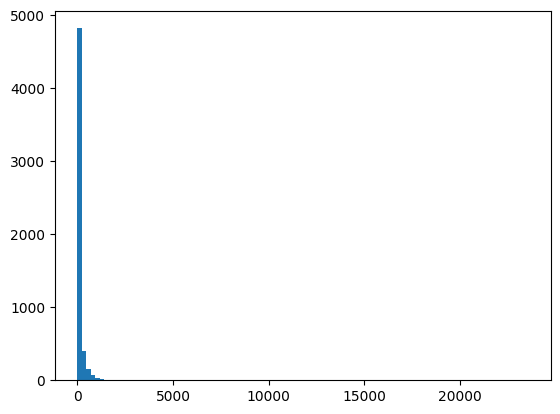

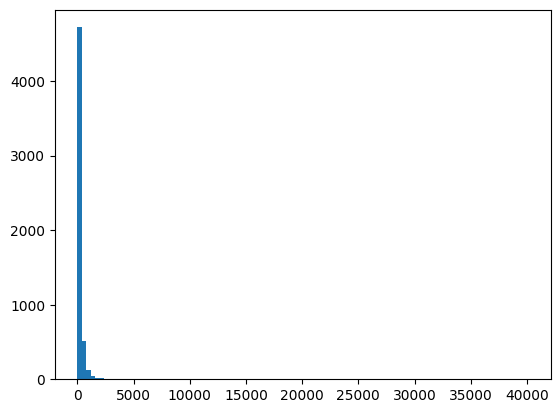

8
12300.278
4700.303
W_Call after offers


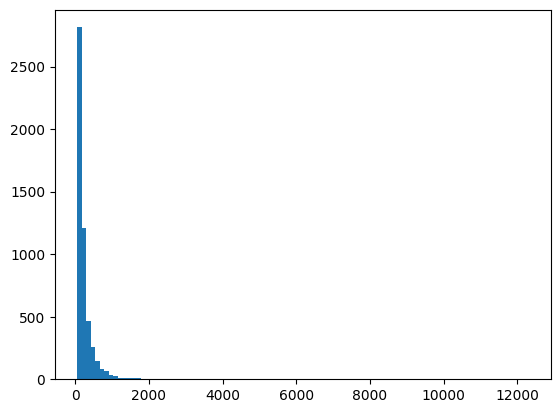

W_Call incomplete files


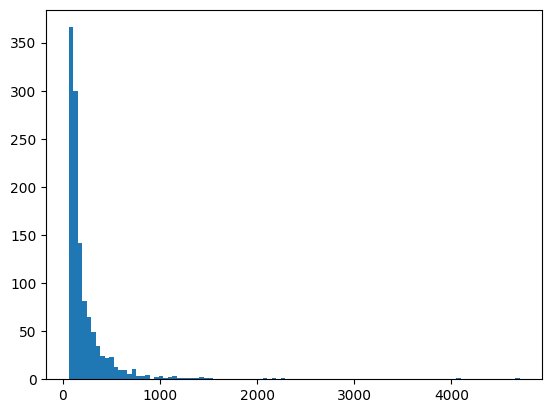

13 15
{'Action': 'Obtained', 'org:resource': 'User_96', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_272763374', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 10, 27, 14, 34, 50, 269000, tzinfo=datetime.timezone.utc)}
{'Action': 'Released', 'org:resource': 'User_96', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_530300024', 'lifecycle:transition': 'suspend', 'time:timestamp': datetime.datetime(2016, 10, 27, 17, 24, 39, 3000, tzinfo=datetime.timezone.utc)}
[{'Action': 'Obtained', 'org:resource': 'User_96', 'concept:name': 'W_Call after offers', 'EventOrigin': 'Workflow', 'EventID': 'Workitem_272763374', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2016, 10, 27, 14, 34, 50, 269000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_96', 'concept:name': 'A_Complete', 'EventOrigin': 'Application', 'EventID': 'ApplState_61468030

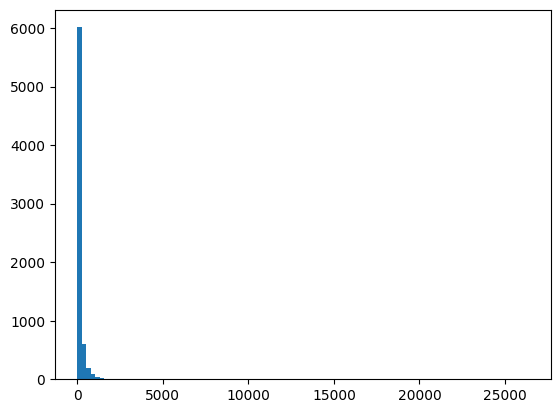

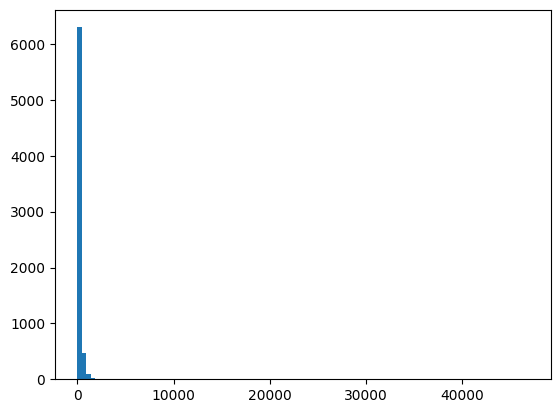

8
12527.361
5056.641
W_Call after offers


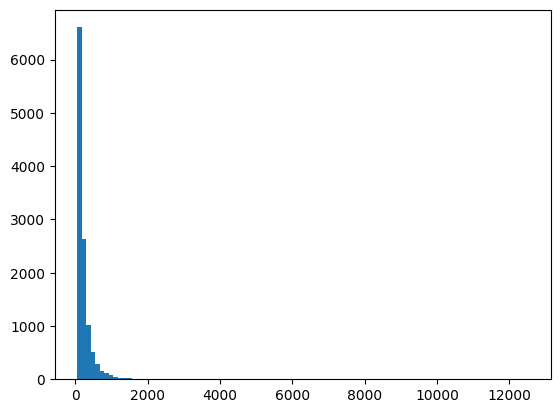

W_Call incomplete files


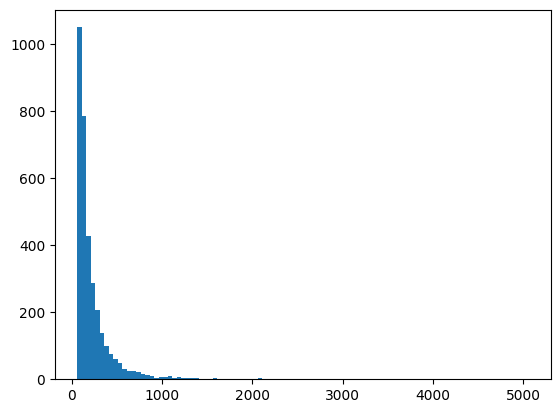

5515 6989


In [12]:
TIME_DIFF = 0
MIN_SPEAKING_TIME = 60
SPEAK_THRESHOLD = 600
DAY_DIFFERENCE = 20
durations = {}
def construct_log(log):
    terminal_states = ['A_Cancelled COMPANY', 'A_Cancelled CUSTOMER', 'A_Pending', 'TIMEOUT']#, 'A_Denied']
    to_merge = ['W_Call incomplete files', 'W_Call after offers', 'W_Complete application', 'W_Validate application']
    log_activities = []
    for trace in log:
        current_trace = [trace[0]]
        for i in range(1,len(trace)):
            pos = trace[i]
            if "W_Call" in trace[i]['concept:name']:
                # search for closing event
                if pos['lifecycle:transition'] in ["start", "resume"]:
                    for inner_index in range(i+1, len(trace)):
                        inner_pos = trace[inner_index]
                        if pos['concept:name'] == inner_pos['concept:name']:
                            if inner_pos['lifecycle:transition'] in ["suspend", "complete"]:                 
                                duration = (inner_pos['time:timestamp']-pos['time:timestamp']).total_seconds()
                                if duration > MIN_SPEAKING_TIME:
                                    if duration > 10000:
                                        print(i, inner_index)
                                        print(pos)
                                        print(inner_pos)
                                        print(trace[i: inner_index+1])
                                        print("#########")
                                    if pos['concept:name'] in current_trace[-1]["concept:name"]:
                                        current_trace[-1]["duration"] += duration
                                    else:
                                        current_trace.append(pos)
                                        current_trace[-1]['duration'] = duration
                                    if current_trace[-1]["duration"] < SPEAK_THRESHOLD:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" SHORT"
                                    elif current_trace[-1]["duration"] < 14400:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" LONG"
                                    else:
                                        current_trace[-1]['concept:name'] = pos['concept:name']+" SUPER LONG"
                                    if pos['concept:name'] not in durations:
                                        durations[trace[i]['concept:name']] = []
                                    durations[trace[i]['concept:name']].append(duration)
                            break
            if "W_" in trace[i]['concept:name']:
                continue
            if trace[i]['concept:name'] in ["A_Created", "A_Complete", "A_Incomplete"]:
                continue
            if trace[i]['concept:name'] == "A_Cancelled":
                current_trace.append(pos)
                if (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).days >= DAY_DIFFERENCE:
                    current_trace[-1]['concept:name'] = "TIMEOUT"
                else:
                    current_trace[-1]['concept:name'] += " CUSTOMER"
                continue
            if "O_Created" == trace[i]['concept:name']:
                continue # merge create and created
            """
            if "A_Cancelled" == trace[i]['concept:name']:
                current_trace.append(pos)
                if (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).days >28:
                    current_trace[-1]['concept:name'] = current_trace[-1]['concept:name']+" AUTO"
                else:
                    current_trace[-1]['concept:name'] = current_trace[-1]['concept:name']+" USER"
            """
            if trace[i]['concept:name'] in terminal_states:
                current_trace.append(pos)
            else:
                if trace[i]['concept:name'] in to_merge and trace[i]['concept:name'] == trace[i-1]['concept:name']:
                    continue
                elif (trace[i]['time:timestamp']-trace[i-1]['time:timestamp']).total_seconds()>TIME_DIFF:
                    current_trace.append(pos)
        if "A_Pending" in [pos['concept:name'] for pos in current_trace]:
            if "O_Cancelled" in [pos['concept:name'] for pos in current_trace]:
                for pos1 in current_trace:
                    if 'O_Cancelled' in pos1['concept:name']:
                        current_trace.remove(pos1)
        intersection = [i for i in trace if i['concept:name'] in terminal_states]

        for state in terminal_states:
            indices = [i for i, x in enumerate(current_trace) if x['concept:name'] == state]
            if indices:
                current_trace = current_trace[:indices[0]+1]

        # assert that if 'A_Pending' contained, trace end with positive
        if 'A_Pending' in [i['concept:name'] for i in trace]:
            if(current_trace[-1]['concept:name'] != 'A_Pending'):
                print(current_trace[-5:-1])
            assert(current_trace[-1]['concept:name'] == 'A_Pending') 

        if intersection:
            log_activities.append(current_trace)
            
    duration_incomplete_list = []
    duration_offer_list = []
    for trace in log_activities:
        duration_incomplete = 0
        duration_offer = 0
        for pos in trace:
            if "W_Call incomplete files" in pos["concept:name"]:
                duration_incomplete += pos["duration"]
            if "W_Call after offers" in pos["concept:name"]:
                duration_offer += pos["duration"]
        duration_incomplete_list.append(duration_incomplete)
        duration_offer_list.append(duration_offer)
    plt.hist(duration_incomplete_list,100)
    plt.show()
    plt.hist(duration_offer_list,100)
    plt.show()
    
    print(len(durations))
    after_offers = durations["W_Call after offers SHORT"]+durations["W_Call after offers LONG"]
    incomplete_files = durations["W_Call incomplete files SHORT"]+durations["W_Call incomplete files LONG"]
    print(max(after_offers)) 
    print(max(incomplete_files))
    print("W_Call after offers")
    plt.hist(after_offers, 100)
    plt.show()
    print("W_Call incomplete files")
    plt.hist(incomplete_files, 100)
    plt.show()
    
    return log_activities

print(len(filtered_log_before), len(filtered_log_after))
filtered_log_before = construct_log(filtered_log_before)
filtered_log_after = construct_log(filtered_log_after)
print(len(filtered_log_before), len(filtered_log_after))

In [13]:
def contains(trace, element):
    for event in trace:
        if event['concept:name']==element:
            return True
        
# process log to iterate created offers
MAX_INDEX = 100
def unroll_log(log):
    
    for trace in log:
        #trace.insert(0,{'concept:name': "start"})
        isPositive = False
        if contains(trace, 'A_Pending'):
            isPositive = True
        trace.insert(0,{'concept:name': "start"})
        if isPositive:
            trace.append({'concept:name': "positive"})
        else:
            trace.append({'concept:name': "negative"})
    
    to_extend = ["O_Create Offer", "O_Created", "W_Call after offers", "W_Call incomplete files", "W_Validate application", "O_Sent (mail and online)", "O_Sent (online only)"]
    to_extend = ["O_Create Offer"]
    for name in to_extend:
        element = 0
        max_trace = 0
        max_index = 0
        for trace in log:
            indices = [i for i, x in enumerate(trace) if x['concept:name'] == name]
            for i in indices:
                count_indices = [j for j in indices if j < i]
                index = MAX_INDEX if len(count_indices) > MAX_INDEX else len(count_indices)
                trace[i]['concept:name'] += " "+str(index)
                if len(count_indices)>max_index:
                    max_index = len(count_indices)
                    element = trace[i]['concept:name']
                    max_trace = trace
        print(element, max_trace)
    return log

unroll_log(filtered_log_before)
unroll_log(filtered_log_after)

O_Create Offer 3 [{'concept:name': 'start'}, {'Action': 'Created', 'org:resource': 'User_1', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application', 'EventID': 'Application_929235447', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 5, 20, 23, 6, 448000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_1', 'concept:name': 'A_Submitted', 'EventOrigin': 'Application', 'EventID': 'ApplState_1030091491', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 5, 20, 23, 6, 498000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_14', 'concept:name': 'A_Concept', 'EventOrigin': 'Application', 'EventID': 'ApplState_397745173', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 1, 6, 7, 29, 56, 893000, tzinfo=datetime.timezone.utc)}, {'Action': 'statechange', 'org:resource': 'User_49', 'concept:name': 'A_Accepted', 'EventOrigin': 'App

[[{'concept:name': 'start'},
  {'Action': 'Created', 'org:resource': 'User_1', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application', 'EventID': 'Application_1714944401', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 8, 1, 6, 9, 48, 705000, tzinfo=datetime.timezone.utc)},
  {'Action': 'statechange', 'org:resource': 'User_1', 'concept:name': 'A_Submitted', 'EventOrigin': 'Application', 'EventID': 'ApplState_743368031', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 8, 1, 6, 9, 48, 795000, tzinfo=datetime.timezone.utc)},
  {'Action': 'statechange', 'org:resource': 'User_1', 'concept:name': 'A_Concept', 'EventOrigin': 'Application', 'EventID': 'ApplState_823206900', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2016, 8, 1, 6, 10, 33, 153000, tzinfo=datetime.timezone.utc)},
  {'Action': 'statechange', 'org:resource': 'User_51', 'concept:name': 'A_Accepted', 'EventOrigin': 'Application', 

In [14]:
def plot_negative_positive(log):
    outcome = ["positive" if "positive" in [i['concept:name'] for i in trace] else "negative" for trace in log]
    total = sum([Counter(outcome)[k] for k in Counter(outcome)])
    print(Counter(outcome), "sum", total, "fraction", Counter(outcome)["positive"]/total)
plot_negative_positive(filtered_log_before)
plot_negative_positive(filtered_log_after)

Counter({'negative': 2907, 'positive': 2608}) sum 5515 fraction 0.4728921124206709
Counter({'negative': 3699, 'positive': 3290}) sum 6989 fraction 0.47073973386750606


In [15]:
REMOVE_THRESHOLD = 0

def ms(trace):
    multiset = {}
    for pos in trace:
        if pos['concept:name'] not in multiset:
            multiset[pos['concept:name']] = 1
        else:
            multiset[pos['concept:name']] += 1
    return json.dumps(multiset, sort_keys=True).encode()

def hist(trace): 
    hist = str(trace[0]['concept:name'])
    for pos in trace[1:]:
        hist += " - " + str(pos['concept:name'])
    return hist

def transition_system(log, threshold = 0, history = 1, actors = {}):
    edges = []
    edge_counter = {}
    controll = {}
    action = {}
    edge_mapping = {}
    for trace_index in range(len(log)):
        trace = log[trace_index]
        s = "start"
        assert(trace[0]['concept:name']=="start")
        for pos_index in range(1,len(trace)):
            pos = trace[pos_index]
            activity = pos['concept:name']
            controllable = True
            for key in actors:
                if key in activity:
                    controllable = actors[key]=='company'
            #t = ms(trace[max(0,pos_index-history+1):pos_index+1])
            t = hist(trace[max(0,pos_index-history+1):pos_index+1])
            e = (s,t)
            controll[e] = controllable
            action[e] = activity
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
                edge_mapping[e] = [trace_index]
            else:
                edge_counter[e] = edge_counter[e]+1
                edge_mapping[e].append(trace_index)
            s = t
    g = nx.DiGraph()
    for e in edges:
        g.add_edge(e[0], e[1])
    to_remove = []
    trace_index_to_remove = []
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        if edge_counter[e] <= threshold:
            for trace_index in edge_mapping[e]:
                trace_index_to_remove.append(trace_index)
        g[e[0]][e[1]]['controllable'] = controll[e]
        g[e[0]][e[1]]['action'] = action[e]
        if not controll[e]:
            g[e[0]][e[1]]['prob_weight'] = len(edge_mapping[e])

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
    print("numer of removed index", len(trace_index_to_remove))
    
    log_reduced = copy.deepcopy(log)
    for index in trace_index_to_remove:
        log_reduced.pop(index)
    
    if threshold>0:
        return transition_system(log_reduced, history = history, actors = actors)
    
    return g, edge_mapping

with open('data/activities.xml') as f:
    data = f.read()
actors = json.loads(data)

system_before, edge_mapping_before = transition_system(filtered_log_before, REMOVE_THRESHOLD, history = 3, actors = actors)
system_after, edge_mapping_after = transition_system(filtered_log_after, REMOVE_THRESHOLD, history = 3, actors = actors)

numer of removed index 0
numer of removed index 0


In [16]:
# compute weights
def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i]['concept:name'] == s and trace[i+1]['concept:name'] == t:
            return True
    return False

def weight(trace):
    return 1 if any("positive" in pos['concept:name'] for pos in trace) else -1

def entropy(p1, p2):
    if p1 == 0 or p2 == 0:
        return 0
    return - p1*np.log2(p1) - p2* np.log2(p2)

def distribution(s,t,log, edge_mapping):
    distr = {1.0: 0 , -1.0 : 0}
    assert((s,t) in edge_mapping)
    for trace_index in edge_mapping[(s,t)]:
        w = weight(log[trace_index])
        distr[w] += 1 #
    return distr[1], distr[-1]

def compute_edge_cost(g, traces, edge_mapping):
    #weights = [1 if "finished" in i else -1 for i in traces]
    edge_cost = {}
    counter = 1
    for s in g.nodes:
        counter +=1
        for t in g[s]:
            #if s == "start" or s == "fin" or t == "start" or t == "fin":
                #continue
            #print("s:", s, "t:",t)
            
            p1, p2 = distribution(s,t,traces, edge_mapping)
            w = 1 if p1 >= p2 else -1
            #print("distribution", p1, p2)
            wp1 = p1/(p1+p2)
            wp2 = p2/(p1+p2)
            #w = majority(s,t,traces)
            scaling = 10
            entro = entropy(wp1, wp2)
            #print("entropy",wp1, wp2,entro)
            edge_cost[(s,t)] = (((1-entro) * w) -0.21 )*200
            #print(edge_cost[(s,t)])
    return edge_cost

edge_cost_before = compute_edge_cost(system_before, filtered_log_before, edge_mapping_before)
edge_cost_after = compute_edge_cost(system_after, filtered_log_after, edge_mapping_after)

In [17]:
def draw_dfg(g, name, layout = "sfdp"):
    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
                edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)
    
def annotate_graph(g, edge_cost):
    for e in edge_cost:
        g[e[0]][e[1]]['label'] = round(edge_cost[e],2)
    return g

def color_graph(g, green = 4, red = -4):
    g = copy.deepcopy(g)
    for e in g.edges:
        if g[e[0]][e[1]]['label'] > green:
            g[e[0]][e[1]]['color'] ="green"
        elif g[e[0]][e[1]]['label'] < red:
            g[e[0]][e[1]]['color'] ="red"
        else:
            g[e[0]][e[1]]['color'] ="gray"
    
    return g

g_before = annotate_graph(system_before, edge_cost_before)
g_before_colored = color_graph(g_before)
draw_dfg(g_before, "graph_weight_before.ps", "dot")
draw_dfg(g_before_colored, 'colored_before.ps', "dot")


g_after = annotate_graph(system_after, edge_cost_after)
g_after_colored = color_graph(g_after)
draw_dfg(g_after, "graph_weight_after.ps", "dot")
draw_dfg(g_after_colored, 'colored_after.ps', "dot")

Plotted graph_weight_before.ps
Plotted colored_before.ps
Plotted graph_weight_after.ps
Plotted colored_after.ps


In [18]:
def print_cycles(g):
    for c in nx.simple_cycles(g):
        count = 0
        c.append(c[0])
        for i in range(len(c)-1):
            count += g[c[i]][c[i+1]]['label']
        print(len(c))
        print("count", count)
print_cycles(g_before)
print("########")
print_cycles(g_after)

5
count -968.0
10
count -1778.0
10
count -1778.0
6
count -1174.15
5
count 632.0
########
5
count -968.0
5
count 632.0
3
count 316.0


In [19]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True
    
# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        if debug:
            print(len(G_gen.nodes), len(queue))
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split(".")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "." not in t:
                            t += ".1"
                        else:
                            t = t.split(".")[0]+"."+str(int(t.split(".")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G[s_original][t_original]):
                    G_gen[s][t]['controllable'] = G[s_original][t_original]['controllable']
                if('prob_weight' in G[s_original][t_original]):
                    G_gen[s][t]['prob_weight'] = G[s_original][t_original]['prob_weight']

    print("Graph was unrolled")
    return G_gen

In [20]:
target = [s for s in g_before_colored.nodes if "positive" in s or "negative" in s]
g_before_unroll = unroll(g_before_colored, "start", target, 1)
target = [s for s in g_after_colored.nodes if "positive" in s or "negative" in s]
g_after_unroll = unroll(g_after_colored, "start", target, 1)

Graph was unrolled
Graph was unrolled


In [21]:
def final_sound(g):
    # positive final states (should be one)
    positives = []
    for s in g.nodes:
        if "positive" in s:
            positives.append(s)
            print(s)
    assert(len(positives) == 1)
    
final_sound(g_before_unroll)
final_sound(g_after_unroll)

O_Accepted - A_Pending - positive
O_Accepted - A_Pending - positive


In [22]:
# insertions can force an edge_count of 1
for e in edge_mapping_before:
    if len(edge_mapping_before[e])==1:
        assert("Call" in e[1] or "TIMEOUT" in e[1] or "CUSTOMER" in e[1] or "Create Offer")

In [23]:
def get_states(g_before, g_after):
    states_set = set()
    for s in g_before.nodes:
        states_set.add(s)
    for s in g_after.nodes:
        states_set.add(s)
    states_set = list(states_set)
    states_set.sort()
    states = {}
    for n,i in zip(list(states_set),range(1,len(states_set)+1)): # reserve 0 for start state
        if n == "start":
            continue
        states[n] = str(i)
    states["start"] = "0"
    return states

def to_prism(g, name, states):
    states = copy.deepcopy(states)
    if "start" not in states:
        states["start"] = "0"
    assert(states["start"] == "0")
    
    terminal = [s for s in g if "neg" in s or "pos" in s]
    
    f = open("/home/paul/Downloads/prism-games-3.1/prism/generated/"+name, "w+")
    f.write('smg \n')
    f.write('player P1 providerModule endplayer \n')
    f.write('player P2 userModule endplayer \n')
    
    # write global variables
    
    f.write('global gas : [-10000..10000] init 0; \n')
    f.write('global state : [0..100000] init 0; \n')
    f.write('global user : bool; \n')
    f.write('global provider : bool; \n')
    
    f.write('global negative : bool; \n')
    f.write('global positive : bool; \n')
    f.write('global final_gas : [-1000..1000] init 0; \n')
    f.write('global steps : [0..1000] init 0; \n')
    
    f.write("const double q = 1/2; \n")
    
    states_max = max([int(states[x]) for x in states])+1000
    for n,i in zip(list(g.nodes),range(states_max, len(g.nodes)+states_max)):
        if n not in states:
            states[n] = str(i)
        
    edges_user = []
    edges_provider = []
    
    user_control = {}
    provider_control = {}
    
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]] and not g[e[0]][e[1]]["controllable"]:
            edges_user.append(e)
            user_control[str(e[0])] = True
        else:
            edges_provider.append(e)
            provider_control[str(e[0])] = True
            
    f.write('module userModule \n')
    outgoing_edges = {} # stores user-actions from state
    for e in edges_user:
        if e[1] == e[0]:
            print("same")
        if e[0] not in outgoing_edges:
            outgoing_edges[e[0]] = [e]
        else:
            outgoing_edges[e[0]].append(e)
            
    for state in outgoing_edges:
        # might have weight 1 bc. after removing are edges re-named
        out_sum = sum([g[element[0]][element[1]]["prob_weight"] for element in outgoing_edges[state]])
        
        # first edge
        e = outgoing_edges[state][0]
        weight = 0
        if "label" in g[e[0]][e[1]]:
            weight = int(g[e[0]][e[1]]["label"])
        prob = g[e[0]][e[1]]["prob_weight"]
        f.write('[] state='+ states[state] + " & user ->")
        f.write(str(prob)+"/"+str(out_sum)+" : "+"(state'="+ states[e[1]]+" ) & (user'=false) & (gas' = gas + "+str(weight)+") & (steps' = steps+1)")
        if e[1] in terminal:
            f.write(" & (final_gas' = gas + "+str(weight)+")")
            if "pos" in e[1]:
                f.write(" & (positive' = true) ")
            else:
                f.write(" & (negative' = true) ")
        for e in outgoing_edges[state][1:]:
            weight = 0
            if "label" in g[e[0]][e[1]]:
                weight = int(g[e[0]][e[1]]["label"])
            prob = g[e[0]][e[1]]["prob_weight"]
            f.write(" + " + str(prob)+"/"+str(out_sum)+" : "+"(state'="+ states[e[1]]+" ) & (user'=false) & (gas' = gas + "+str(weight)+") & (steps' = steps+1)")
            if e[1] in terminal:
                f.write(" & (final_gas' = gas + "+str(weight)+")")
                if "pos" in e[1]:
                    f.write(" & (positive' = true) ")
                else:
                    f.write(" & (negative' = true) ")
        f.write("; \n")
    """
    for e in edges_user:
        weight = 0
        if "label" in g[e[0]][e[1]]:
            weight = int(g[e[0]][e[1]]["label"])
        f.write('[] state='+ states[e[0]] + " & user -> (state'="+ states[e[1]]+" ) & (user'=false) & (gas' = gas + "+str(weight)+") & (steps' = steps+1)")
        if e[1] in terminal:
            f.write(" & (final_gas' = gas + "+str(weight)+")")
            if "pos" in e[1]:
                f.write(" & (positive' = true) ")
            else:
                f.write(" & (negative' = true) ")
        f.write("; \n")
    """
    
    # user chooses to not take an action
    for s in states:
        if s in user_control and user_control[s]:
            if s in provider_control and provider_control[s]:
                f.write('[] state='+ states[s] + " & user -> (provider'=true) & (user'=false); \n")
    f.write('endmodule \n')
    
    f.write('module providerModule \n')
    for e in edges_provider:
        weight = 0
        if "label" in g[e[0]][e[1]]:
            weight = int(g[e[0]][e[1]]["label"])         
        f.write('[] state='+ states[e[0]] + " & provider -> (state'="+ states[e[1]]+" ) & (provider'=false) & (gas' = gas + "+str(weight)+") & (steps' = steps+1)")
        if e[1] in terminal:
            f.write(" & (final_gas' = gas + "+str(weight)+")")
            if "pos" in e[1]:
                f.write(" & (positive' = true) ")
            else:
                f.write(" & (negative' = true) ")
        f.write("; \n")
    f.write('endmodule \n')
    
    f.write('module controll \n')
    for s in states:
        if s in user_control and user_control[s] and s in provider_control and provider_control[s]:
            f.write("[] state="+ states[s] + " & !user & !provider -> q : (provider' = true) + (1-q) : (user' = true); \n")
        elif s in user_control and user_control[s]:
            f.write("[] state="+ states[s] + " & !user & !provider -> (user' = true); \n")
        elif s in provider_control and provider_control[s]:
            f.write("[] state="+ states[s] + " & !user & !provider -> (provider' = true); \n")
        else:
            if s in g and "neg" not in s and "pos" not in s:
                print("no one controlls", s)
                print(len(g.out_edges(s)))
            assert(False or len(g.out_edges(s))==0)
            
    for s in terminal:
        f.write("[] state="+ states[s] + " & !user & !provider -> (state' = "+ str(states[s])+")")
        if "pos" in s:
            f.write(" & (positive' = true) ")
        if "neg" in s:
            f.write(" & (negative' = true) ")
        f.write("; \n")
    f.write('endmodule \n')
    
def to_prism_loops(g, name, states, q = 0.5):
    states = copy.deepcopy(states)
    if "start" not in states:
        states["start"] = "0"
    assert(states["start"] == "0")
    
    terminal = [s for s in g if "neg" in s or "pos" in s]
    
    f = open("/home/paul/Downloads/prism-games-3.1/prism/generated/"+name, "w+")
    f.write('smg \n')
    
    # write global variables
    
    f.write('global gas : [-10000..10000] init 0; \n')
    f.write('global state : [0..100000] init 0; \n')
    f.write('global user : bool; \n')
    f.write('global provider : bool; \n')
    
    f.write('global negative : bool; \n')
    f.write('global positive : bool; \n')
    f.write('global final_gas : [-1000..1000] init 0; \n')
    f.write('global steps : [0..1000] init 0; \n')
    """
    f.write('global state : [0..100000] init 0; \n')
    f.write('global user : bool; \n')
    f.write('global provider : bool; \n')
    
    f.write('global negative : bool; \n')
    f.write('global positive : bool; \n')
    """
    f.write("const double q = " + str(q) + "; \n")
    
    states_max = max([int(states[x]) for x in states])+1000
    for n in g.nodes:
        assert(n in states)

    edges_user = []
    edges_provider = []
    
    user_control = {}
    provider_control = {}
    
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]] and not g[e[0]][e[1]]["controllable"]:
            edges_user.append(e)
            user_control[str(e[0])] = True
        else:
            edges_provider.append(e)
            provider_control[str(e[0])] = True
            
    f.write('module userModule \n')

    outgoing_edges = {} # stores user-actions from state
    for e in edges_user:
        if e[1] == e[0]:
            print("same")
        if e[0] not in outgoing_edges:
            outgoing_edges[e[0]] = [e]
        else:
            outgoing_edges[e[0]].append(e)
    
    transition_names_with_weights_actor = {}
    neg_transitions = {}
    feedback_states = {} # store intermediate states for reward value
    for state in outgoing_edges:
        # might have weight 1 bc. after removing are edges re-named
        out_sum = sum([g[element[0]][element[1]]["prob_weight"] for element in outgoing_edges[state]])
        
        # first edge
        e = outgoing_edges[state][0]

        prob = g[e[0]][e[1]]["prob_weight"]
        f.write('[] state='+ states[state] + ' & user ->')
        states_max += 1
        feedback_states[e[1]] = str(states_max)
        f.write(str(prob)+"/"+str(out_sum)+" : "+"(state'="+ feedback_states[e[1]]+" ) & (user'=false) ")
        if e[1] in terminal:
            if "pos" in e[1]:
                f.write(" & (positive' = true) ")
            else:
                f.write(" & (negative' = true) ")
        for e in outgoing_edges[state][1:]:
            weight = 0
            if "label" in g[e[0]][e[1]]:
                weight = int(g[e[0]][e[1]]["label"])
            prob = g[e[0]][e[1]]["prob_weight"]
            states_max += 1
            feedback_states[e[1]] = str(states_max)
            f.write(" + " + str(prob)+"/"+str(out_sum)+" : "+"(state'="+ feedback_states[e[1]]+" ) & (user'=false) ")
            if e[1] in terminal:
                if "pos" in e[1]:
                    f.write(" & (positive' = true) ")
                else:
                    f.write(" & (negative' = true) ")
        f.write("; \n")

        # write transition and feedback states
        for e in outgoing_edges[state]:
            weight = 0
            if "label" in g[e[0]][e[1]]:
                weight = int(g[e[0]][e[1]]["label"])

            #name different from actual state; named after state before "split"
            transition_name = "from"+states[e[0]]+"to"+states[e[1]] 
            
            assert(transition_name not in transition_names_with_weights_actor)
            transition_names_with_weights_actor[transition_name] = (weight, False)
            
            f.write('['+transition_name+'] state='+ feedback_states[e[1]] + "-> (state' = "+ states[e[1]]+"); \n")

    # user chooses to not take an action
    for s in states:
        if s in user_control and user_control[s]:
            if s in provider_control and provider_control[s]:
                f.write('[] state='+ states[s] + " & user -> (provider'=true) & (user'=false); \n")
    f.write('endmodule \n')
    
    f.write('module providerModule \n')
    for e in edges_provider:
        weight = 0
        if "label" in g[e[0]][e[1]]:
            weight = int(g[e[0]][e[1]]["label"])
        
        transition_name = "from"+states[e[0]]+"to"+states[e[1]]
        assert(transition_name not in transition_names_with_weights_actor)
        transition_names_with_weights_actor[transition_name] = (weight, True)

        f.write('['+transition_name+'] state='+ states[e[0]] + " & provider -> (state'="+ states[e[1]]+" ) & (provider'=false) ")
        if e[1] in terminal:
            if "pos" in e[1]:
                f.write(" & (positive' = true) ")
            else:
                f.write(" & (negative' = true) ")
        f.write("; \n")
    f.write('endmodule \n')
    
    f.write('module controll \n')
    for s in states:
        if s in user_control and user_control[s] and s in provider_control and provider_control[s]:
            f.write("[] state="+ states[s] + " & !user & !provider -> q : (provider' = true) + (1-q) : (user' = true); \n")
        elif s in user_control and user_control[s]:
            f.write("[] state="+ states[s] + " & !user & !provider -> (user' = true); \n")
        elif s in provider_control and provider_control[s]:
            f.write("[] state="+ states[s] + " & !user & !provider -> (provider' = true); \n")
        else:
            if s in g and "neg" not in s and "pos" not in s:
                print("no one controlls", s)
                print(len(g.out_edges(s)))
            assert(False or len(g.out_edges(s))==0)
            
    for s in terminal:
        f.write("[] state="+ states[s] + " & !user & !provider -> (state' = "+ str(states[s])+")")
        if "pos" in s:
            f.write(" & (positive' = true) ")
        if "neg" in s:
            f.write(" & (negative' = true) ")
        f.write("; \n")
    f.write('endmodule \n')

    f.write('player P1 \n')
    for transition in transition_names_with_weights_actor:
        weight, controllable = transition_names_with_weights_actor[transition]
        if controllable:
            f.write("[" + transition + "]"+ ", ")
    f.write("providerModule \n")
    f.write('endplayer \n')

    f.write('player P2 \n')
    for transition in transition_names_with_weights_actor:
        weight, controllable = transition_names_with_weights_actor[transition]
        if not controllable:
            f.write("[" + transition + "]"+ ", ")
    f.write("userModule \n")
    f.write('endplayer \n')

    f.write('rewards "pos" \n')
    for transition in transition_names_with_weights_actor:
        weight, controllable = transition_names_with_weights_actor[transition]
        if weight >= 0:
            f.write("["+transition+"] true : "+ str(weight)+"; \n")
    f.write('endrewards \n')

    f.write('rewards "neg" \n')
    for transition in transition_names_with_weights_actor:
        weight, controllable = transition_names_with_weights_actor[transition]
        if weight < 0:
            f.write("["+transition+"] true : "+ str(min(abs(weight),2000))+"; \n")
    f.write('endrewards \n')

    

"""
G=nx.DiGraph()
G.add_nodes_from(["start","2","3","pos"])
G.add_edges_from([("start","2", {"prob_weight":1}),("start","3", {"prob_weight":1}),("2","3", {"controllable":False, "prob_weight":1, "label": -1}),("3", "2", {"prob_weight":1}), ("2", "pos", {"controllable":False, "prob_weight":1, "label": 1})])
print("nodes", G.nodes)
target = "pos"

pos = nx.planar_layout(G)
states = get_states(G, G)
print("states", states)
to_prism_loops(G, "generated.prism", states)
"""


states = get_states(g_before, g_after)
print("before")
to_prism(g_before_unroll, "before_generated.prism",states)
to_prism_loops(g_before, "before_with_loops.prism", states, q = 0.54)
print("after")
to_prism(g_after, "after_cyclic.prism",states)
to_prism(g_after_unroll, "after_generated.prism", states)
to_prism_loops(g_after, "after_with_loops.prism", states, q = 0.63)

before
after


In [24]:
print([k for k in states if states[k] == "0"])
print([k for k in states if states[k] == "13"])

['start']
['A_Validating - O_Returned - A_Validating']


Graph was unrolled


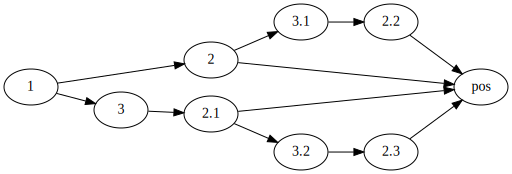

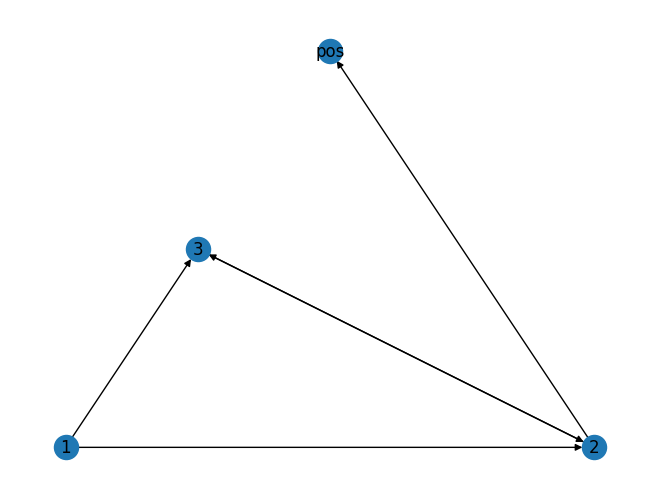

In [25]:
G=nx.DiGraph()
# example 1
#G.add_nodes_from(["1","2","3","4","5"])
#G.add_edges_from([("1","2"),("2","3"),("3","2"),("2","4"),("4","2"),("2","5")])
#target = "5"

# example 2
#G.add_nodes_from(["1","2","3","4","5"])
#G.add_edges_from([("1","2"),("1","3"),("3","2"),("2", "3"),("2","4"),("4","3"),("4","5")])
#target = "5"

# example 3
#G.add_nodes_from(["1","2","3","4"])
#G.add_edges_from([("1","2"),("2","3"),("2","4"),("4", "2")])
#target = "3"

# example 4
G.add_nodes_from(["1","2","3","pos"])
G.add_edges_from([("1","2", {"controllable":False}),("1","3"),("2","3"),("3", "2"), ("2", "pos")])
target = "pos"

pos = nx.planar_layout(G)
nx.draw(G, with_labels = True, pos = pos)

k = 1
start = "1"

G_gen = unroll(G, start,[target],1)
A = to_agraph(G_gen)
A.layout('dot', args='-Grankdir=LR')
A.draw('gen.png')
A

In [26]:
results = {}
def query(g, g_unrolled, q, node_threshold = 0):
    cycle_nodes = [item for sublist in list(nx.simple_cycles(g)) for item in sublist]
    cycle_nodes = set([x[0] for x in cycle_nodes])
    results = {}
    for s in g.nodes:
        sub_nodes = set(list(nx.descendants(g, s)))
        sub_nodes.add(s)
        if len(sub_nodes) > node_threshold:
            continue
        subgraph = nx.subgraph(g, sub_nodes)
        subgraph = nx.DiGraph(subgraph)

        # add start node to subgraph
        start_nodes = []
        for n in subgraph.nodes:
            if subgraph.in_degree(n) == 0:
                start_nodes.append(n)
        assert(len(start_nodes)<=1)
        for n in start_nodes:
            subgraph.add_edge("start", n)
            subgraph["start"][n]["controllable"] = True
            subgraph["start"][n]["label"] = 0
        # if initial node lies on cycle, per default set as start node
        if "start" not in subgraph.nodes:
            subgraph.add_edge("start", s)
            subgraph["start"][s]["controllable"] = True
            subgraph["start"][s]["label"] = 0

        target = [s for s in subgraph.nodes if "positive" in s or "negative" in s]

        if s not in cycle_nodes:
            unrolled_subnotes = set(list(nx.descendants(g_unrolled, s)))
            unrolled_subnotes.add(s)
            subgraph_unrolled = nx.subgraph(g_unrolled, unrolled_subnotes)
            subgraph_unrolled = nx.DiGraph(subgraph_unrolled)
            subgraph_unrolled.add_edge("start", s)
            subgraph_unrolled["start"][s]["controllable"] = True
            subgraph_unrolled["start"][s]["label"] = 0
        else:
            subgraph_unrolled = unroll(subgraph, "start", target, 1)

        positives = []
        for pos_end in subgraph_unrolled.nodes:
            if "positive" in pos_end:
                positives.append(pos_end)
        assert(len(positives) <= 1)
        
        
        to_prism(subgraph_unrolled, "generated.prism", states)
        out = subprocess.Popen([PRISM_PATH, "/home/paul/Downloads/prism-games-3.1/prism/generated/generated.prism", q], stdout=subprocess.PIPE)
        out.wait()
        result_prob = float(str(out.communicate()[0]).split("Result: ")[1].split(" ")[0])
        results[s] = result_prob
        print(result_prob)
    return results
    
# not called anymore - dont need substeps, can fetch results from prism intermediate file
results = query(g_after, g_after_unroll, "/home/paul/Downloads/prism-games-3.1/prism/generated/queries/pos.props")

In [27]:
def draw_dfg(g, name, names=[], layout = "sfdp", color_map = []):

    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
                #edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")

    for n in A.nodes():
        if n in names:
            new = names[n]
            if isinstance(names[n], float): 
                new = round(names[n], 2)
            if new == 1:
                n.attr['label'] = "pos"
            elif new == 0:
                n.attr['label'] = "neg"
            else:
                n.attr["label"] = ""
        if n in color_map:
            n.attr['color'] = color_map[n]
    
        n.attr['fontsize'] = 80
        n.attr['penwidth'] = 20
        n.attr['height'] = 2
        n.attr['width'] = 2

    for e in A.edges():
        e.attr['penwidth'] = 15
        e.attr["fontsize"] = 80
        e.attr["label"] = ""
        e.attr["color"] = "black"
            
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    A.draw(name)
    print("Plotted", name)

#draw_dfg(g_after, "after_results.png", names = results, layout = "dot")

#plot_reduction(g_before, "before_reduced.png", results_file, layout = "dot")

In [28]:

def compute_color_map(g, results_file):
    c = ["darkred","red","lightcoral", "palegreen","green","darkgreen"]
    v = [0,0.15,0.4,0.6,0.9,1]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)
    s = cmap(0.23)
    map = {}
    for s in g.nodes():
        map[s] = rgb2hex(cmap(results_file[s])) # have to convert to hex color
    return map

def can_be_merged(g, results_file):
    for s in g.nodes():
        reachable_values = [round(results_file[t],2) for t in g[s]]
        if round(results_file[s],2) in reachable_values:
        #if len(set(reachable_values)) == 1 and reachable_values[0] == round(results_file[s],2):
            return s
    return None

"""
NOTE: One positive and one negative node is kept and all remaining from positive/negative cluster are merged into them.
"""
def reduce_graph(g, results_file):
    neg_cluster = []
    pos_cluster = []
    print("size", len(g.nodes()))
    s = can_be_merged(g, results_file)
    while(s != None):
        for t in g[s]:
            if round(results_file[t],2) != round(results_file[s],2):
                continue
            g = nx.contracted_nodes(g, s, t, self_loops = False)
        s = can_be_merged(g, results_file)

    print("size", len(g.nodes()))
    for s in g:
        if results_file[s] == 0:
            neg_cluster.append(s)
        if results_file[s] == 1:
            pos_cluster.append(s)
    for s in pos_cluster[1:]:
        g = nx.contracted_nodes(g, pos_cluster[0], s, self_loops=False)
    for s in neg_cluster[1:]:
        g = nx.contracted_nodes(g, neg_cluster[0], s, self_loops=False)



    g.remove_edges_from(nx.selfloop_edges(g))

    print("size", len(g.nodes()))
    return g

def compute_reduction(g, states, q = 0.5, unrolled_model = False):

    g = copy.deepcopy(g)
    
    model_path = "/home/paul/Downloads/prism-games-3.1/prism/generated/reduction_model.prism"

    # generate model & start query
    to_prism_loops(g, "reduction_model.prism", states, q = q)
    f = open("/home/paul/Downloads/prism-games-3.1/prism/generated/intermediate_output", "w")
    subprocess.call([PRISM_PATH, model_path, "/home/paul/Downloads/prism-games-3.1/prism/generated/queries/pos.props","-verbose"], stdout = f)
    f.close()

    # process results
    df = pd.read_csv("/home/paul/Downloads/prism-games-3.1/prism/generated/intermediate_output", skiprows=51, header=None, skipfooter=6, engine ="python")
    df[0] = df[0].str.split("(").str[1]
    h = df[7].str.split("\)=")
    df[7] = h.str[0]
    df[8] = h.str[1]

    # convert types
    df = df.rename(columns = {0: "gas", 1: "state", 2: "user", 3: "provider", 4:"negative", 5:"positive", 6:"finalGas", 7:"steps", 8:"result"})
    df["gas"] = pd.to_numeric(df["gas"])
    df["state"] = pd.to_numeric(df["state"])
    df["finalGas"] = pd.to_numeric(df["finalGas"])
    df["steps"] = pd.to_numeric(df["steps"])
    df["result"] = pd.to_numeric(df["result"])

    # only rows where not decided who takes action
    df1 = df.drop(df[(df["user"]) | (df["provider"]) ].index)
    for s in g.nodes():
        assert s in states

    # check if all unrolled states have same result
    results_file = {}
    int_states = {}
    for s in states:
        int_states[s] = int(states[s])
    for s in int_states:
        state_entry = df1[df1["state"] == int_states[s]]
        if state_entry.empty:
            assert(s in states)
            results_file[s] = 0
            continue
        results_file[s] = list(state_entry["result"])[0]
        assert(len(state_entry["result"]) == 1)

    # assert that all states are used
    df1_states = list(df1["state"])
    for s in df1_states:
        stored_states = [k for k in states if s == int_states[k]]
        if len(stored_states) != 1:
            assert(s > 1000)

    return results_file
    # TODO for cyclic models
    if unrolled_model:
        cycle_nodes = [item for sublist in list(nx.simple_cycles(g)) for item in sublist]
        
    for s in int_states:
        if s in cycle_nodes:
            print("skip")
            continue
        state_entry = df1[df1["state"] == int_states[s]]
        if state_entry.empty:
            print(int_states[s])
            print(state_entry)
            print("empty")
            continue
        results_file[s] = list(state_entry["result"])[0]
        assert(len(set(state_entry["result"])) == 1)
        print(int_states[s])
        print(min(state_entry["gas"]), max(state_entry["gas"]), list(state_entry["result"])[0])

def plot_reduction(g, name, results_file, layout = "sdf"):
    g = copy.deepcopy(g)
    #g = color_graph(g, results_file)
    g = reduce_graph(g, results_file)

    print("reduced", len(g.nodes))

    # compute color map
    color_map = compute_color_map(g, results_file)

    draw_dfg(g, name, names = results_file, layout = "dot", color_map=color_map)

def lost_users_cost(g, results_file, edge_mapping, strategy):
    users_lost, users_lost_edge = lost_users(g, results_file, edge_mapping, strategy)
    return sum([users_lost_edge[k] for k in users_lost_edge]) # could also maximize pos or max sum etc.

def lost_users(g, results_file, edge_mapping, strategy):
    #search for "to-repair" edges
    users_lost = {}
    users_lost_edge = {}
    for s in g.nodes():
        in_sum = 0
        for e in g.in_edges(s):
            assert(e[0] in strategy)
            if e[1] not in strategy[e[0]]:
                continue # skip "avoidable" edges in recommendations
            prob = 1
            if not g[e[0]][e[1]]["controllable"]:
                out_sum = 0
                for out_edge in g[e[0]]:
                    if not g[e[0]][out_edge]["controllable"]:
                        out_sum += g[e[0]][out_edge]["prob_weight"]
                prob = len(edge_mapping[e]) / out_sum
            in_sum += len(edge_mapping[e])*(results_file[e[0]]-results_file[e[1]])* prob
            #if g[e[0]][e[1]]["controllable"]:
            #    print(len(edge_mapping[e])*(results_file[e[0]]-results_file[e[1]]))
            users_lost_edge[e] = len(edge_mapping[e])*(results_file[e[0]]-results_file[e[1]])*prob
        users_lost[s] = (1-results_file[s])*in_sum
    return users_lost, users_lost_edge

def get_strategy(g, states, exec=True, query = "/home/paul/Downloads/prism-games-3.1/prism/generated/queries/pos.props"):
    if exec:
        dummy_file = "/home/paul/Downloads/prism-games-3.1/prism/generated/dummy"
        print("running PRISM-games")
        FNULL = open(os.devnull, 'w')
        to_prism_loops(g, "reduction_model.prism", states)
        print("plotted model")
        subprocess.call([PRISM_PATH, "/home/paul/Downloads/prism-games-3.1/prism/generated/reduction_model.prism", query, "--exportstrat", dummy_file], stdout=subprocess.DEVNULL)
    
    strat_df = pd.read_csv(STRATEGY_PATH, sep = " ", header = None)
    strat_df = strat_df.dropna()

    strategy = {}
    for action in strat_df[1]:
        s = action[4:].split("to")
        e = (s[0], s[1])
        original_0 = [s for s in states if states[s]== e[0]]
        original_1 = [s for s in states if states[s]== e[1]]
        assert(len(original_0)== 1 and len(original_1)==1)
        original_0 = original_0[0]
        original_1 = original_1[0]
        if original_0 not in strategy:
            strategy[original_0] = [original_1]
        else:
            strategy[original_0].append(original_1)

    for s in g.nodes():
        if s not in strategy:
            strategy[s] = [] 

    return strategy

def draw_strategy(g, strategy, name):
    for k in strategy:
        for t in strategy[k]:
            g[k][t]['color'] = "red"
    draw_dfg(g, name, layout="dot")

strategy = get_strategy(g_before, states)
results_file = compute_reduction(g_before, states, q = 0.54)
print("before", len(g_before.nodes))
plot_reduction(g_before, "before_reduced.png", results_file, layout = "dot")
users_lost, users_lost_edge = lost_users(g_before, results_file, edge_mapping_before, strategy)
print("cost", lost_users_cost(g_before, results_file, edge_mapping_before, strategy))
print([(k,users_lost[k]) for k in users_lost if users_lost[k] > 100])
print(sum([users_lost[k] for k in users_lost if users_lost[k] > 0]))
print([(k,users_lost_edge[k]) for k in users_lost_edge if users_lost_edge[k] > 100])
draw_strategy(g_before, strategy, "before_strat.ps")

results_file_after = compute_reduction(g_after, states, q = 0.63)
plot_reduction(g_after, "after_reduced.png", results_file_after, layout = "dot")

running PRISM-games
plotted model
before 152
size 152
size 34
size 25
reduced 25
Plotted before_reduced.png
cost -658.9075694443449
[('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 566.2767110517234), ('O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT', 570.212645058941)]
1482.038170342682
[(('A_Accepted - O_Create Offer 0 - O_Sent (mail and online)', 'O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT'), 986.218422090536), (('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT'), 148.0847393845379), (('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT'), 516.1274751947553)]
Plotted before_strat.ps
size 167
size 43
size 31
reduced 31
Plotted after_reduced.png


# Repair recommendations BPIC

In [29]:
def plot_repair_recommendations(g, states, q, edge_mapping):
    strategy = get_strategy(g, states)
    results_file = compute_reduction(g, states, q = q)
    users_lost, users_lost_edge = lost_users(g, results_file, edge_mapping, strategy)

    sorted_edges = [(k,v) for k, v in sorted(users_lost_edge.items(), key=lambda item: item[1], reverse=True)]
    total = sum([k[1] for k in sorted_edges if k[1] > 0])
    print("total", total)
    print("ratio", total/sum([k[1] for k in sorted_edges if k[1] < 0]))
    weights = []
    names = []
    for i in range(5):
        print(sorted_edges[i], sorted_edges[i][1]/total)
        weights.append(sorted_edges[i][1])
        names.append(str(sorted_edges[i][0]))
    colors = ["red" if "TIMEOUT" in name else "orange" if "Call" in name else "green" for name in names]
    plt.scatter(range(len(weights)),weights, c = colors)
    plt.show()

    timeout_lost = 0
    offer_call_lost = 0
    incomplete_call_lost = 0
    for k,v in sorted_edges:
        if "TIMEOUT" in k[1]:
            timeout_lost += v
        if "W_Call after offers" in k[1].split("-")[-1]:
            offer_call_lost += v
        if "W_Call incomplete files" in k[1].split("-")[-1]:
            incomplete_call_lost += v

    print("timeout", timeout_lost/total)
    print("offer call", offer_call_lost/total)
    print("incomplete call", incomplete_call_lost/total)
    return {k : v for (k,v) in sorted_edges[:5]}

running PRISM-games
plotted model
total 2033.9936934916732
ratio -0.7553168478498352
(('A_Accepted - O_Create Offer 0 - O_Sent (mail and online)', 'O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT'), 986.218422090536) 0.48486798422542576
(('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT'), 516.1274751947553) 0.2537507745703678
(('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT'), 148.0847393845379) 0.07280491569780972
(('W_Call after offers SHORT - O_Create Offer 1 - O_Sent (mail and online)', 'O_Create Offer 1 - O_Sent (mail and online) - TIMEOUT'), 69.9234415080882) 0.03437741313152919
(('O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT'), 48.26560671691209) 0.02372947707328262


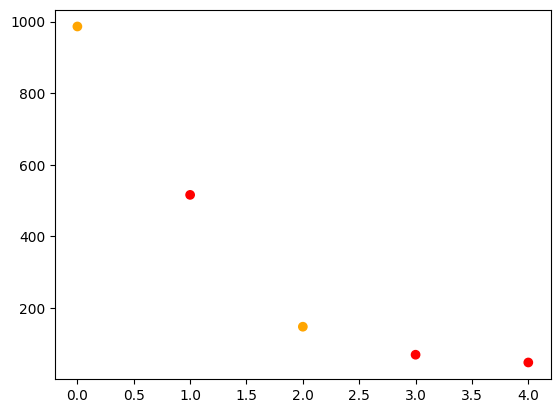

timeout 0.36125618228489353
offer call 0.5138401286128278
incomplete call 0.09976948664126452


In [30]:
before_recommendations = plot_repair_recommendations(g_before, states, 0.54, edge_mapping_before)

running PRISM-games
plotted model
total 2523.226993003478
ratio -0.7655811585480015
(('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT'), 993.0952604099094) 0.3935814190176351
(('A_Accepted - O_Create Offer 0 - O_Sent (mail and online)', 'O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT'), 804.7779795043823) 0.31894791143876805
(('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT'), 244.7834722828279) 0.09701206944978591
(('O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT'), 101.9713541632404) 0.04041307200897555
(('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers LONG', 'O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT'), 70.44381905113637) 0.027918145789683723


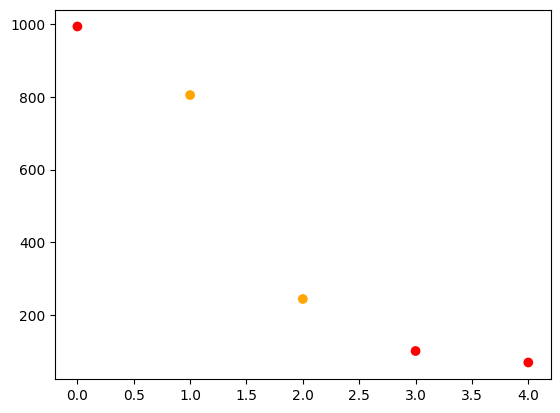

timeout 0.5018793794205839
offer call 0.3423721984818842
incomplete call 0.13015809252472732


In [31]:
after_recommendations = plot_repair_recommendations(g_after, states, 0.63, edge_mapping_after)

In [32]:
for e in after_recommendations:
    print(e in before_recommendations)

True
True
True
True
False


# Alternative Edge Construction

In [33]:
def get_alternative_edges(g):
    sum = 1
    alternative_edges = []
    for s in g.nodes():
        if len(g[s])>1:
            controllable = []
            for t in g[s]:
                if g[s][t]['controllable']:
                    controllable.append((s,t))
            if len(controllable)>1:
                sum *= len(controllable)
                alternative_edges.append(controllable)
    return alternative_edges
    

def filter_alternative_edges_by_result(g, states, edge_mapping, epsilon, alternative_edges):
    print(len(alternative_edges))
    strategy = get_strategy(g, states)
    results_file = compute_reduction(g, states)
    current_user_loss = lost_users_cost(g, results_file, edge_mapping, strategy)
    assert("start" in results_file)
    current_result = results_file["start"]

    print(current_user_loss, current_result)

    edge_lists_to_remove = []

    min_user_loss = current_user_loss
    reduced_result = current_result
    for edges in alternative_edges:
        active_edge = [e for e in edges if e[1] in strategy[e[0]] ]
        assert(len(active_edge) == 1)
        active_edge = active_edge[0]
        g_copy = copy.deepcopy(g)
        print("removed", active_edge)
        g_copy.remove_edge(active_edge[0], active_edge[1])
        results_file_removed = compute_reduction(g_copy, states)
        strategy_removed = get_strategy(g_copy, states)
        user_loss_removed = lost_users_cost(g_copy, results_file_removed, edge_mapping, strategy_removed)

        print(current_result, results_file_removed["start"], user_loss_removed)
        print(round(current_result,2), round(results_file_removed["start"],2), user_loss_removed)

        if abs( round(current_result,2) - round(results_file_removed["start"],2))>epsilon:
            print("cant remove active edge")
            edge_lists_to_remove.append(edges)
        else:
            print("can remove edge")
            if min_user_loss > user_loss_removed:
                min_user_loss = user_loss_removed
                reduced_result = results_file_removed["start"]
                print("optimal removed", active_edge)

    for edges in edge_lists_to_remove:
        alternative_edges.remove(edges)

    print(len(alternative_edges))
    print("min", min_user_loss, reduced_result, min_user_loss/current_user_loss)

alternative_edges = get_alternative_edges(g_before)
filter_alternative_edges_by_result(g_before, states, edge_mapping_before, 0.0, alternative_edges)
print(len(alternative_edges))

27
running PRISM-games
plotted model
-883.5126138902914 0.4110979017248599
removed ('A_Concept - A_Accepted - O_Create Offer 0', 'A_Accepted - O_Create Offer 0 - O_Sent (mail and online)')
running PRISM-games
plotted model
0.4110979017248599 0.3241775864555263 -338.9660155364141
0.41 0.32 -338.9660155364141
cant remove active edge
removed ('A_Accepted - O_Create Offer 0 - O_Sent (mail and online)', 'O_Create Offer 0 - O_Sent (mail and online) - O_Create Offer 1')
running PRISM-games
plotted model
0.4110979017248599 0.3485979017248599 -1051.9774843064145
0.41 0.35 -1051.9774843064145
cant remove active edge
removed ('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - A_Validating')
running PRISM-games
plotted model
0.4110979017248599 0.3847889391627285 -27.7754028869443
0.41 0.38 -27.7754028869443
cant remove active edge
removed ('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Retur

In [34]:
def edge_cost(edge_mapping, results_file, e):
    return len(edge_mapping[e])*(results_file[e[0]]-results_file[e[1]])

def optimize_strategy(g, states, edge_mapping, epsilon, alternative_edges, strategy, results_file, users_lost_edge):
    strategy = copy.deepcopy(strategy)
    removed_edges = []
    for edges in alternative_edges:
        # current edge in strategy
        current_active_edge = [e for e in edges if e[1] in strategy[e[0]] ]
        assert(len(current_active_edge) == 1)
        current_active_edge = current_active_edge[0]
        current_cost = edge_cost(edge_mapping, results_file, current_active_edge) # dont need new results_file when epsilon = 0 -> changes only allowed if prob. of both new nodes are equal (enforced through )
        # compute best edge to be included in strategy
        best_option = current_active_edge
        for edge in edges:
            new_cost = edge_cost(edge_mapping, results_file, edge)
            if new_cost < current_cost:
                print("update", new_cost, current_cost)
                current_cost = new_cost
                best_option = edge
        
        if best_option != current_active_edge:
            # remove current active edge
            removed_edges.append(current_active_edge)
            strategy[current_active_edge[0]].remove(current_active_edge[1])
            # add current active edge
            strategy[current_active_edge[0]].append(best_option[1])
            print("removed", current_active_edge, "added", best_option)
        
    g_copy = copy.deepcopy(g)
    for edge in removed_edges:
        g_copy.remove_edge(edge[0], edge[1])
        print("removed from list", edge)

    print("finished")
    results_file_checked = compute_reduction(g_copy, states)
    print("checked_results", results_file_checked["start"])
    strategy_checked = get_strategy(g_copy, states)

    print(lost_users_cost(g_copy, results_file_checked, edge_mapping, strategy_checked))

    return strategy

final_strategy = optimize_strategy(g_before, states, edge_mapping_before, 0.0, alternative_edges, strategy, results_file, users_lost_edge)
print("before", lost_users_cost(g_before, results_file, edge_mapping_before, strategy))
print("after", lost_users_cost(g_before, results_file, edge_mapping_before, final_strategy))

update -289.79999999999995 -137.07999999999998
removed ('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incomplete files SHORT - O_Accepted') added ('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned - W_Call incomplete files SHORT - A_Validating')
update -63.48 -18.4
removed ('A_Validating - O_Returned - W_Call incomplete files LONG', 'O_Returned - W_Call incomplete files LONG - O_Accepted') added ('A_Validating - O_Returned - W_Call incomplete files LONG', 'O_Returned - W_Call incomplete files LONG - A_Validating')
update -4.851997601891616 -0.5874450866403198
removed ('O_Create Offer 0 - O_Create Offer 1 - O_Sent (mail and online)', 'O_Create Offer 1 - O_Sent (mail and online) - A_Validating') added ('O_Create Offer 0 - O_Create Offer 1 - O_Sent (mail and online)', 'O_Create Offer 1 - O_Sent (mail and online) - O_Sent (mail and online)')
removed from list ('A_Validating - O_Returned - W_Call incomplete files SHORT', 'O_Returned

[(('A_Accepted - O_Create Offer 0 - O_Sent (mail and online)', 'O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT'), 986.218422090536), (('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT'), 148.0847393845379), (('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT'), 516.1274751947553)]
(('A_Accepted - O_Create Offer 0 - O_Sent (mail and online)', 'O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT'), 986.218422090536)
(('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 'O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT'), 516.1274751947553)
(('W_Call after offers SHORT - A_Validating - O_Returned', 'A_Validating - O_Returned - W_Call incomplete files SHORT'), 148.0847393845379)
(('W_Call after offers SHORT - O_Create Offer 1 - O_Sent (mail and online)', '

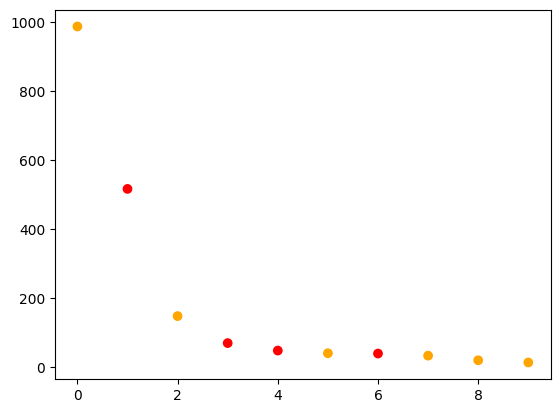

In [35]:
# in optimized strategy, consider how 
users_lost_optimized, users_lost_edge_optimized = lost_users(g_before, results_file, edge_mapping_before, final_strategy)
print([(e, users_lost_edge_optimized[e]) for e in users_lost_edge_optimized if users_lost_edge_optimized[e] > 100])

sorted_edges = [(k,v) for k, v in sorted(users_lost_edge_optimized.items(), key=lambda item: item[1], reverse=True)]
weights = []
names = []
for i in range(10):
    print(sorted_edges[i])
    weights.append(sorted_edges[i][1])
    names.append(str(sorted_edges[i][0]))
colors = ["red" if "TIMEOUT" in name else "orange" if "Call" in name else "green" for name in names]
plt.scatter(range(len(weights)),weights, c = colors)
plt.show()

In [36]:
sorted_edges = [(k,v) for k, v in sorted(users_lost_optimized.items(), key=lambda item: item[1], reverse=True)]
weights = []
names = []
for i in range(10):
    print(sorted_edges[i])
    weights.append(sorted_edges[i][1])
    names.append(str(sorted_edges[i][0]))
colors = ["red" if "TIMEOUT" in name else "orange" if "Call" in name else "green" for name in names]
plt.scatter(range(len(weights)),weights, c = colors)
plt.show()

('O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT', 570.212645058941)
('O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT', 566.2767110517234)
('A_Validating - O_Returned - W_Call incomplete files SHORT', 90.0116555576769)
('O_Create Offer 1 - O_Sent (mail and online) - TIMEOUT', 89.41839126549975)
('O_Sent (mail and online) - W_Call after offers LONG - TIMEOUT', 43.19158229670639)
('O_Sent (mail and online) - O_Sent (mail and online) - W_Call after offers SHORT', 23.16433225463774)
('O_Sent (mail and online) - W_Call after offers SHORT - A_Cancelled CUSTOMER', 22.729858451601565)
('O_Create Offer 2 - O_Sent (mail and online) - TIMEOUT', 12.765629454545454)
('O_Create Offer 0 - O_Sent (mail and online) - TIMEOUT', 12.721560258339181)
('O_Returned - W_Call incomplete files SHORT - A_Cancelled CUSTOMER', 9.72)


KeyboardInterrupt: 

In [ ]:
# test if removed node (unonncected) still gets strategy -> no, only reachable nodes get strategy (but all, even if would not be reached under strategy)

('A_Accepted - O_Create Offer 0 - O_Create Offer 1', 'O_Create Offer 0 - O_Create Offer 1 - O_Sent (mail and online)')


def draw_strategy(g, strategy, name):
    for k in strategy:
        for t in strategy[k]:
            print(k,t)
            g[k][t]['color'] = "red"
    draw_dfg(g, name, layout="dot")

g_copy = copy.deepcopy(g_before)
g_copy['A_Accepted - O_Create Offer 0 - O_Create Offer 1']['O_Create Offer 0 - O_Create Offer 1 - O_Sent (mail and online)']['controllable'] = False
g_copy['A_Accepted - O_Create Offer 0 - O_Create Offer 1']['O_Create Offer 0 - O_Create Offer 1 - O_Sent (mail and online)']['prob_weight'] = 0
results_file_removed = compute_reduction(g_copy, states)
strategy_removed = get_strategy(g_copy, states)
user_loss_removed = lost_users_cost(g_copy, results_file_removed, edge_mapping_before, strategy_removed)

print(results_file_removed["start"], user_loss_removed)
draw_strategy(g_copy, strategy_removed, "reduced_strat.ps")

running PRISM-games
plotted model
0.4110979017248599 -832.6283034761378
start start - A_Create Application
A_Accepted - O_Create Offer 0 - A_Cancelled CUSTOMER O_Create Offer 0 - A_Cancelled CUSTOMER - negative
A_Accepted - O_Create Offer 0 - O_Cancelled O_Create Offer 0 - O_Cancelled - O_Create Offer 1
A_Accepted - O_Create Offer 0 - O_Create Offer 1 O_Create Offer 0 - O_Create Offer 1 - O_Create Offer 2
A_Accepted - O_Create Offer 0 - O_Create Offer 1 O_Create Offer 0 - O_Create Offer 1 - O_Cancelled
A_Accepted - O_Create Offer 0 - O_Sent (mail and online) O_Create Offer 0 - O_Sent (mail and online) - O_Create Offer 1
A_Accepted - O_Create Offer 0 - O_Sent (mail and online) O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers SHORT
A_Accepted - O_Create Offer 0 - O_Sent (mail and online) O_Create Offer 0 - O_Sent (mail and online) - W_Call after offers LONG
A_Accepted - O_Create Offer 0 - O_Sent (mail and online) O_Create Offer 0 - O_Sent (mail and online) - A_Cancelled 

# GrepS usecase

In [ ]:
# removes unused events and parses event names
def process_touchpoint_names(df):
    running_df = df[df['Type'].isin(['state', 'feedback','subject', 'task'])].copy()
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(",", "")
    running_df['concept:name'] = running_df['concept:name'].str.split('version').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.split('Time used').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.split('taskDownloaded').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.split('testCompleted').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.split('itemCompleted').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.strip()

    m = running_df['concept:name'].str.contains("survey:")
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].str.split('survey: ').str[1]

    m = running_df['Type'] == 'state'
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].values
    running_df.loc[~m, 'concept:name'] = running_df['concept:name'][~m].values
    return running_df

# Filters the dataset to only contain traces with length in [lower_bound, upper_bound]
def get_filtered_df(path, lower_bound = 15, upper_bound = 60):
    df = pd.read_csv(path, index_col = 0, sep=";")
    log_csv = dataframe_utils.convert_timestamp_columns_in_df(df)
    log_csv = log_csv.sort_values('Timestamp')

    developers_finished_ids = set(log_csv[log_csv['Message'] == "finished"]['Developer ID'].sort_values().values)

    #rename columns to process mining notation
    log_csv.rename(columns={'Developer ID': 'case:DeveloperID', 'Message' : 'concept:name', 'Timestamp':'time:timestamp'}, inplace=True)
    log_csv['time:timestamp'] = pd.to_datetime(log_csv['time:timestamp'], unit='s')

    # process touchpoint names
    developers_df = process_touchpoint_names(log_csv)

    #filter used logs
    developers_df = developers_df.groupby(['case:DeveloperID']).filter(lambda x: len(x) >= lower_bound and len(x) <= upper_bound)

    unsuccesfull = developers_df[~developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    succesfull = developers_df[developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    plt.scatter(range(len(unsuccesfull)), unsuccesfull, c = "r", s = 7)
    plt.scatter(range(len(unsuccesfull),len(unsuccesfull)+(len(succesfull))), succesfull, c = "b", s = 7)
    plt.xlabel("Journeys")
    plt.ylabel("Length")
    plt.show()
    print("Includes #unsuccesfull:", len(unsuccesfull),"and #succesfull", len(succesfull))
    
    print("Histograms")
    sns.displot(data=pd.DataFrame({"Journey Length - Successfull": succesfull}),
            x="Journey Length - Successfull", color='blueviolet', height=3)
    plt.show()
    
    sns.displot(data=pd.DataFrame({"Journey Length - Unsuccessfull": unsuccesfull}),
            x="Journey Length - Unsuccessfull", color='blueviolet', height=3)
    plt.show()
    

    developers_df = developers_df.sort_values(by=['time:timestamp'])

    return developers_df

/tmp/ipykernel_16866/879778145.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/tmp/ipykernel_16866/879778145.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


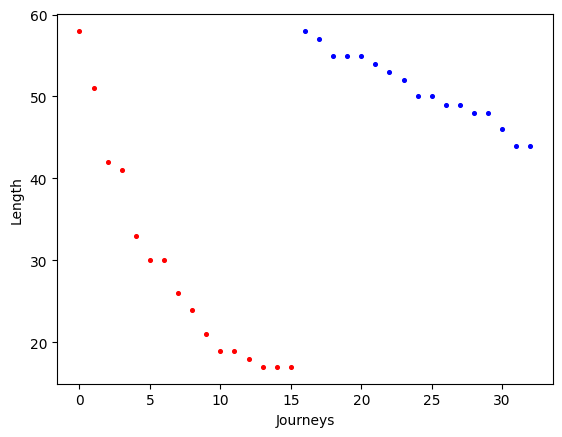

Includes #unsuccesfull: 16 and #succesfull 17
Histograms


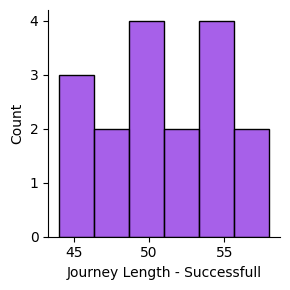

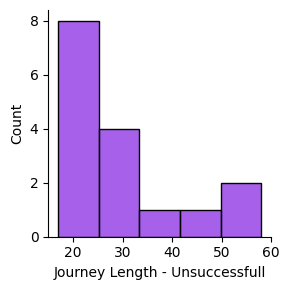

In [ ]:
greps_filtered_df = get_filtered_df("data/data.csv")

In [ ]:
success_states = ['finished']
# A log consists of traces, where each trace contains all elements from one developer 
def build_log(df):
    log = []
    running_df = df.copy()
    running_df = running_df.sort_values(by=['time:timestamp'])
    developers_id = set(running_df['case:DeveloperID'].values)
    for dev_id in developers_id:
        current_trace = running_df[running_df['case:DeveloperID'] == dev_id]['concept:name'].values
        current_trace = [{"concept:name": e} for e in current_trace]
        # add unique start node "start"
        current_trace = np.insert(current_trace,0,{"concept:name": "start"})
        # attach final node finPos / finNeg
        touchpoints = [s['concept:name'] for s in current_trace]
        if(any(s in touchpoints for s in success_states)):
            current_trace = np.append(current_trace,{"concept:name": "positive"})
        else:
            current_trace = np.append(current_trace,{"concept:name": "negative"})
        log.append(current_trace)
        
    # alter "logged in: Web page" to determine phase of journey:
    # Phase (1) sign up, (2) solve all programming tasks, and  (3) review and share the skill report with the customer.
    for t in log:
        indices = [i for i, x in enumerate(t) if x['concept:name'] == "Logged in: Web page"]
        for i in indices:
            t[i]['concept:name']= "Logged in: Web page - Sign up"
            result = np.where(t == {"concept:name": "Task event:"})
            names = [h['concept:name'] for h in t]
            if "Task event:" in names and result[0][0] < i:
                t[i]['concept:name'] = "Logged in: Web page - Task"
            result = np.where(t == {"concept:name": "waitingForResultApproval"})
            names = [h['concept:name'] for h in t]
            if "waitingForResultApproval" in names and result[0][0] < i:
                t[i]['concept:name'] = "Logged in: Web page - Approval"
                
    # add task number
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x['concept:name'] == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x['concept:name'] == "Task event:"]
        for i in indices_task:
            count_indices = [j for j in indices_feedback if j < i] # uses feedback to increase task counter after giving feedback
            t[i]['concept:name'] += " "+str(len(count_indices))
    # add feedback number        
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x['concept:name'] == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x['concept:name'] == "Task event:"]
        for i in indices_feedback:
            count_indices = [j for j in indices_feedback if j < i]
            t[i]['concept:name'] += " "+str(len(count_indices))
    
    return log

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

In [ ]:
greps_log = build_log(greps_filtered_df)

In [ ]:
with open('data/activities_greps.xml') as f:
    data = f.read()
greps_actors = json.loads(data)

# todo change greps format to other one
greps_system, greps_edge_mapping = transition_system(greps_log, threshold = REMOVE_THRESHOLD, history = 1, actors = greps_actors)



# remove infrequent edges -> was done in greps paper
to_remove = []
for e in greps_system.edges():
    if len(greps_edge_mapping[e])<= 0:
        to_remove.append(e)

for e in to_remove:
    greps_system.remove_edge(e[0], e[1])
    greps_edge_mapping.pop(e)

for n in list(nx.isolates(greps_system)):
    greps_system.remove_node(n)

# drop nod without outgoing
#greps_system.remove_node("waitingForSubjectAcceptance")

greps_system.remove_nodes_from(list(nx.isolates(greps_system)))



greps_edge_cost = compute_edge_cost(greps_system, greps_log, greps_edge_mapping)
greps_graph = annotate_graph(greps_system, greps_edge_cost)
greps_graph_colored = color_graph(greps_graph)
draw_dfg(greps_graph_colored, "greps/greps.ps", layout = "dot")

numer of removed index 0
Plotted greps/greps.ps


In [ ]:
# Queries
greps_states = get_states(greps_system, greps_system)
to_prism_loops(greps_system, "greps_loops.prism", greps_states, q = 0.62)

greps_strategy = get_strategy(greps_system, greps_states)

draw_strategy(greps_system, greps_strategy, "greps/greps_strat.ps")

results_file_greps = compute_reduction(greps_system, greps_states, q = 0.62)

names_greps = {n : n + "." + str(round(results_file_greps[n],2)) for n in results_file_greps}

draw_dfg(greps_graph_colored, "greps/greps.ps", names=names_greps, layout = "dot")

plot_reduction(greps_system, "greps/reduction.png", results_file_greps, layout = "dot")
users_lost_greps, users_lost_edge_greps = lost_users(greps_system, results_file_greps, greps_edge_mapping, greps_strategy)
print("cost", lost_users_cost(greps_system, results_file_greps, greps_edge_mapping, greps_strategy))

# change back to grep's function and compare values

running PRISM-games
plotted model
start vpcAssignInstance
start registered
Logged in: Web page - Approval positive
Logged in: Web page - Approval subjectAcceptanceReceived
Logged in: Web page - Approval waitingForSubjectAcceptance
Logged in: Web page - Sign up started
Logged in: Web page - Task waitingForScores
Logged in: Web page - Task Task event: 2
Logged in: Web page - Task Task event: loggedIn
Logged in: Web page - Task Task event: 3
Logged in: Web page - Task Task event: 4
Logged in: Web page - Task Task event: 0
Logged in: Web page - Task Task event: 1
Results automatically shared waitingForActivityReport
Results automatically shared subjectAcceptanceReceived
Task event: 0 Give feedback 0
Task event: 0 Task event: loggedIn
Task event: 0 Logged in: Web page - Task
Task event: 1 Give feedback 1
Task event: 1 negative
Task event: 1 Logged in: Web page - Task
Task event: 2 Give feedback 2
Task event: 2 negative
Task event: 2 Logged in: Web page - Task
Task event: 2 Task event: logge

In [ ]:
#target = [s for s in greps_system.nodes if "positive" in s or "negative" in s]
#greps_unroll = unroll(greps_system, "start", target, 1)

In [ ]:
#alternative_edges_greps = get_alternative_edges(greps_system)
#filter_alternative_edges_by_result(greps_system, greps_states, greps_edge_mapping, 0.0, alternative_edges_greps)
#print(len(alternative_edges))

#final_strategy_greps = optimize_strategy(greps_system, greps_states, greps_edge_mapping, 0.0, alternative_edges_greps, greps_strategy, results_file_greps, users_lost_edge_greps)
#print("before", lost_users_cost(greps_system, results_file_greps, greps_edge_mapping, greps_strategy))
#print("after", lost_users_cost(greps_system, results_file_greps, greps_edge_mapping, final_strategy_greps))

# dont need "best" strategy

final_strategy_greps = greps_strategy
#draw_strategy(greps_system, final_strategy_greps, "greps/greps_strat_final.ps")

In [ ]:
for k in final_strategy_greps:
    assert(k in greps_strategy)
    if(set(final_strategy_greps[k]) != set(greps_strategy[k])):
        print("before:", greps_strategy[k], "after", final_strategy_greps[k])
    #assert(set(final_strategy_greps[k]) == set(greps_strategy[k]))
print("equal strategy")

equal strategy


[]
total 10.256902376889398
(('Task event: loggedIn', 'Task event: 0'), 4.361256585600173) 0.4252021151558242 T6 T8
(('Task event: 1', 'negative'), 1.5825652415017375) 0.15429270781279295 T10 neg
(('waitingForActivityReport', 'negative'), 1.304794181336567) 0.12721132885855455 T25 neg
(('Task event: 3', 'negative'), 0.896733327431064) 0.08742730450974767 T14 neg
(('Task event: 2', 'negative'), 0.7406235805843104) 0.07220733447293652 T12 neg
(('Logged in: Web page - Approval', 'subjectAcceptanceReceived'), 0.2573825731466073) 0.025093596847186088 T26 T24
(('Task event: 5', 'Logged in: Web page - Task'), 0.2023335476714898) 0.019726574382474656 T18 T20
(('waitingForManualScores', 'Logged in: Web page - Task'), 0.15875849713871884) 0.015478210799434887 T19 T20
(('started', 'Task event: 0'), 0.1540518592580404) 0.015019335623701197 T7 T8
(('Logged in: Web page - Task', 'Task event: loggedIn'), 0.132350510452316) 0.012903555633962642 T20 T6


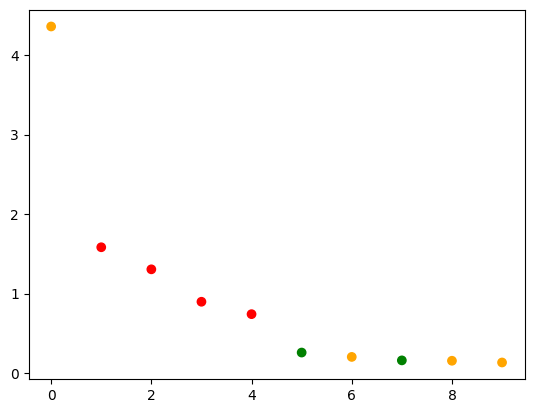

In [ ]:
# in optimized strategy, consider how 
users_lost_optimized_greps, users_lost_edge_optimized_greps = lost_users(greps_system, results_file_greps, greps_edge_mapping, final_strategy_greps)
print([(e, users_lost_edge_optimized_greps[e]) for e in users_lost_edge_optimized_greps if users_lost_edge_optimized_greps[e] > 100])

# Introduced naming for readable function
naming = {
    "registered" : "T0",
    "activated": "T1",
    "Logged in: Web page - Sign up" : "T2",
    "vpcCreateUserOnInstance" : "T3",
    "vpcAssignInstance" : "T4",
    "readyToStart" : "T5",
    "Task event: loggedIn" : "T6",
    "started" : "T7",
    "Task event: 0": "T8",
    "Give feedback 0" : "T9",
    "Task event: 1": "T10",
    "Give feedback 1" : "T11",
    "Task event: 2": "T12",
    "Give feedback 2" : "T13",
    "Task event: 3": "T14",
    "Give feedback 3" : "T15",
    "Task event: 4": "T16",
    "Give feedback 4" : "T17",
    "Task event: 5": "T18",
    "waitingForManualScores" : "T19",
    "Logged in: Web page - Task" : "T20",
    "waitingForScores" : "T21",
    "waitingForResultApproval" : "T22",
    "waitingForSubjectAcceptance" : "T23",
    "subjectAcceptanceReceived" : "T24",
    "Results automatically shared" : "T24",
    "waitingForActivityReport" : "T25",
    "Logged in: Web page - Approval" : "T26",
    "negative" : "neg",
    "positive" : "pos",
    "start": "start",
    "finished":"finished"
}

sorted_edges = [(k,v) for k, v in sorted(users_lost_edge_optimized_greps.items(), key=lambda item: item[1], reverse=True)]
total = sum([k[1] for k in sorted_edges if k[1] > 0])
print("total", total)
weights = []
names = []
for i in range(10):
    print(sorted_edges[i], sorted_edges[i][1]/total, naming[sorted_edges[i][0][0]], naming[sorted_edges[i][0][1]])
    weights.append(sorted_edges[i][1])
    names.append(str(sorted_edges[i][0]))
colors = ["red" if "negative" in name else "orange" if "Task event" in name else "green" for name in names]
plt.scatter(range(len(weights)),weights, c = colors)
plt.show()

In [ ]:
# remove infrequent edges -> was done in greps paper
to_remove = []
for e in greps_system.edges():
    if len(greps_edge_mapping[e])<= 3:
        to_remove.append(e)

for e in to_remove:
    greps_system.remove_edge(e[0], e[1])
    greps_edge_mapping.pop(e)

for n in list(nx.isolates(greps_system)):
    greps_system.remove_node(n)

# drop node without outgoing
greps_system.remove_node("waitingForSubjectAcceptance")

#greps_system = annotate_graph(greps_system, greps_edge_cost)
greps_system = color_graph(greps_system)

In [ ]:
from turtle import pensize

def compute_color_map(g, results_file):
    c = ["darkred","red","lightcoral", "palegreen","green","darkgreen"]
    v = [0,0.15,0.4,0.6,0.9,1]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)
    s = cmap(0.23)
    map = {}
    for s in g.nodes():
        map[naming[s]] = rgb2hex(cmap(results_file[s])) # have to convert to hex color
    return map

def draw_dfg_clustered(g, name):
    # build graph with variable thicknes
    #scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in g.edges:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = 10
        e.attr["fontsize"] = 80
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                e.attr["style"] = "dotted"

    for n in A.nodes():
        n.attr['fontsize'] = 80
        n.attr['penwidth'] = 15
        n.attr['height'] = 2
        n.attr['width'] = 2
        if n in color_greps:
            n.attr['color'] = color_greps[n]
    for e in A.edges():
        e.attr['penwidth'] = 15
        e.attr["fontsize"] = 80

    onboarding = ["T"+str(i) for i in range(0,6)]
    A.add_subgraph(onboarding, name='cluster_onboarding', label= "Sign-up", color = "orange", fontsize = 90, fontcolor = "orange", penwidth= 10)
    task = ["T"+str(i) for i in range(6,21)]
    A.add_subgraph(task, name='cluster_task', label= "Solve tasks", color = "blue", fontsize = 90, fontcolor = "blue", penwidth= 10)
    evaluation = ["T"+str(i) for i in range(21,27)]
    A.add_subgraph(evaluation, name='cluster_evaluation', label= "Review and share", color = "purple", fontsize = 90, fontcolor = "purple", penwidth= 10)
    A.layout("dot")
    A.draw(name)

color_greps = compute_color_map(greps_system, results_file_greps)
greps_clustered = nx.relabel_nodes(greps_system, naming)
draw_dfg_clustered(greps_clustered, 'greps/outgoing_clustered.png')

# Weiterer Code

In [ ]:
def draw_edges(g, name, results, layout = "sfdp"):

    g = copy.deepcopy(g)
    to_remove = []

    for e in results:
        sub_nodes = list(nx.descendants(g, e[0]))
        subgraph = nx.subgraph(g, sub_nodes)
        subgraph = nx.DiGraph(subgraph)

        reachable_weights = set([results[e1] for e1 in subgraph.edges()])
        smaller = [abs(w) < 100 for w in reachable_weights]
        if all(smaller):
            to_remove.extend(sub_nodes)

    for s in to_remove:
        for e in g.in_edges(s):
            if abs(results[e]) > 100:
                to_remove.remove(s)
                continue
        for e in g[s]:
            if abs(results[e]) > 100:
                to_remove.remove(s)
    # might still contain nodes that should not be removed...
    print("O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT" in to_remove)

    g.remove_nodes_from(to_remove)

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    #for e in edge_weights:
        #e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = edge_weights[e]*scaling
        #e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
                #edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")

    for e in A.edges():
        if e in results:
            e.attr['label'] += " lost "+str(round(results[e],2))
            if results[e] > 400:
                e.attr['color'] = "red"
                print("colored", e, results[e])
            elif results[e] < -400:
                e.attr['color'] = "green"
            else:
                e.attr['color'] = "grey"
     
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    A.draw(name)
    print("Plotted", name)


draw_edges(g_before, "h.png", users_lost_edge, layout = "dot")

KeyError: ('A_Concept - A_Accepted - O_Create Offer 0', 'A_Accepted - O_Create Offer 0 - O_Create Offer 1')

In [ ]:
to_prism_loops(g_before, "before_with_loops.prism", states)
f = open("/home/paul/Downloads/prism-games-3.0-linux64/generated/test", "w")
subprocess.call(["/home/paul/Downloads/prism-games-3.0-linux64/bin/prism", "/home/paul/Downloads/prism-games-3.0-linux64/generated/after_generated.prism", "/home/paul/Downloads/prism-games-3.0-linux64/generated/queries/pos.props","-verbose"], stdout = f)
#subprocess.call(["/home/paul/Downloads/prism-games-3.0-linux64/bin/prism", "/home/paul/Downloads/prism-games-3.0-linux64/generated/before_with_loops.prism", "/home/paul/Downloads/prism-games-3.0-linux64/generated/queries/pos.props","-verbose"], stdout = f)
f.close()

In [ ]:
df = pd.read_csv("/home/paul/Downloads/prism-games-3.0-linux64/generated/test", skiprows=51, header=None, skipfooter=6, engine ="python")
df.head()

In [ ]:
df[0] = df[0].str.split("(").str[1]
h = df[7].str.split("\)=")
df[7] = h.str[0]
df[8] = h.str[1]
df.iloc[-10:]
print(df.shape)

In [ ]:
df = df.rename(columns = {0: "gas", 1: "state", 2: "user", 3: "provider", 4:"negative", 5:"positive", 6:"finalGas", 7:"steps", 8:"result"})
df["gas"] = pd.to_numeric(df["gas"])
df["state"] = pd.to_numeric(df["state"])
df["finalGas"] = pd.to_numeric(df["finalGas"])
df["steps"] = pd.to_numeric(df["steps"])
df["result"] = pd.to_numeric(df["result"])
df.head()
print(df.dtypes)

In [ ]:
df1 = df.drop(df[(df["user"]) | (df["provider"]) ].index)
print(df1.shape)
print(df1.head())

In [ ]:
cycle_nodes = [item for sublist in list(nx.simple_cycles(g_after)) for item in sublist]
int_states = {}
for s in states:
    int_states[s] = int(states[s])

results_file = {}
for s in int_states:
    if s in cycle_nodes:
        print("skip")
        continue
    state_entry = df1[df1["state"] == int_states[s]]
    if state_entry.empty:
        print(int_states[s])
        print(state_entry)
        print("empty")
        continue
    results_file[s] = list(state_entry["result"])[0]
    assert(len(set(state_entry["result"])) == 1)
    print(int_states[s])
    print(min(state_entry["gas"]), max(state_entry["gas"]), list(state_entry["result"])[0])
print(results_file.values())
print(len(g_after), len(results_file))

In [ ]:
# extend results_file with either 0 defaults or avg. for states on cycles
for s in g_after:
    if s not in results_file:
        if s in cycle_nodes:
            results_file[s] = np.mean(list(df1[df1["state"] == int_states[s]]["result"]))
        else:
            results_file[s] = 0
    if s in results:
        if round(results[s], 2) != round(results_file[s],2):
            print(s, ":", results[s], results_file[s])
            print(s in cycle_nodes)

In [ ]:
draw_dfg(g_after, "after_results_2.png", results_file, layout = "dot")

In [ ]:
df_final_gas = df.drop(df[ ~ ( (df["negative"]) | (df["positive"]) ) ].index)
print(df_final_gas.head())

In [ ]:
def draw_edges(g, name, results, layout = "sfdp"):
    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    g = copy.deepcopy(g)
    to_remove = []

    for e in results:
        sub_nodes = list(nx.descendants(g, e[0]))
        subgraph = nx.subgraph(g, sub_nodes)
        subgraph = nx.DiGraph(subgraph)

        reachable_weights = set([results[e1] for e1 in subgraph.edges()])
        smaller = [abs(w) < 100 for w in reachable_weights]
        if all(smaller):
            to_remove.extend(sub_nodes)

    for s in to_remove:
        for e in g.in_edges(s):
            if abs(results[e]) > 100:
                to_remove.remove(s)
                continue
        for e in g[s]:
            if abs(results[e]) > 100:
                to_remove.remove(s)
    # might still contain nodes that should not be removed...
    print("O_Sent (mail and online) - W_Call after offers SHORT - TIMEOUT" in to_remove)

    g.remove_nodes_from(to_remove)

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    #for e in edge_weights:
        #e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = edge_weights[e]*scaling
        #e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
                #edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")

    for e in A.edges():
        if e in results:
            e.attr['label'] += " lost "+str(round(results[e],2))
            if results[e] > 400:
                e.attr['color'] = "red"
                print("colored", e, results[e])
            elif results[e] < -400:
                e.attr['color'] = "green"
            else:
                e.attr['color'] = "grey"
     
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    A.draw(name)
    print("Plotted", name)

users_lost = {}
users_lost_edge = {}
for s in results_file:
    in_sum = 0
    for e in g_after.in_edges(s):
        in_sum += len(edge_mapping_after[e])*(results_file[e[0]]-results_file[e[1]])
        users_lost_edge[e] = len(edge_mapping_after[e])*(results_file[e[0]]-results_file[e[1]])
    users_lost[s] = (1-results_file[s])*in_sum


draw_edges(g_after, "after_edges.png", users_lost_edge, layout = "dot")

sorted_edges = [(k,v) for k, v in sorted(users_lost_edge.items(), key=lambda item: abs(item[1]), reverse=True)] # sort by abs value to include biggest gains
for i in range(10):
    print(sorted_edges[i])

In [ ]:
# computes waiting times before action (how fast should company enable interaction)
def idle_times(log):
    times = {}
    for trace in log:
        for pos in range(1,len(trace[:-2])): # can only go until last two elements, transition from second to laste is has no time
            duration = (trace[pos+1]["time:timestamp"]-trace[pos]["time:timestamp"]).total_seconds()
            action = trace[pos+1]["concept:name"]
            if action not in times:
                times[action] = [duration]
            else:
                times[action].append(duration)
    return times 

def get_gaussian_mixture(components, times):
    duration_classifier = {}
    for t in times:
        if len(times[t])==1:
            g = mixture.GaussianMixture(n_components=1,covariance_type='full')
            g.fit(np.array([[times[t]], [times[t]]]).reshape(-1, 1))
            duration_classifier[t] = g
            continue
        
        g = 0
        best_bic = 100000000
        for i in range(1, components+1):
            classifier = mixture.GaussianMixture(n_components=i,covariance_type='full')
            classifier.fit(np.array(times[t]).reshape(-1,1))
            bic = classifier.bic(np.array(times[t]).reshape(-1,1))
            if bic < best_bic:
                best_bist = bic
                g = classifier

        weights = g.weights_
        means = g.means_
        covars = g.covariances_
        
        duration_classifier[t] = g
    return duration_classifier

def get_bayesian_gaussian_mixture(components, times):
    duration_classifier = {}
    for t in times:
        if len(times[t])==1:
            g = mixture.BayesianGaussianMixture(n_components=1,covariance_type='full')
            g.fit(np.array([[times[t]], [times[t]]]).reshape(-1, 1))
            duration_classifier[t] = g
            continue
        
        g = mixture.BayesianGaussianMixture(n_components=components,covariance_type='full', random_state=42)
        g.fit(np.array(times[t]).reshape(-1,1))
        weights = g.weights_
        means = g.means_
        covars = g.covariances_
        
        duration_classifier[t] = g
    return duration_classifier

def classify_log(log, predictor):
    log = copy.deepcopy(log)
    for trace in log:
        for pos in range(1,len(trace[:-2])):
            duration = (trace[pos+1]["time:timestamp"]-trace[pos]["time:timestamp"]).total_seconds()
            action = trace[pos+1]["concept:name"]
            suffix = str(predictor[action].predict(np.array(duration).reshape(1,-1))[0])
            assert(int(suffix) in list(range(0,100)))
            trace[pos+1]["concept:name"] += "#"+suffix

    return log

times = idle_times(filtered_log_before) # waiting times BEFORE action
predictor = get_bayesian_gaussian_mixture(3, times)
discretized_log_before = classify_log(filtered_log_before, predictor)

In [ ]:
system_before_discrete, edge_mapping_before_discrete = transition_system(discretized_log_before, REMOVE_THRESHOLD, history = 3, actors = actors)
edge_cost_before_discrete = compute_edge_cost(system_before_discrete, discretized_log_before, edge_mapping_before_discrete)

In [ ]:
# computes cost for discrete actions, returns dictionary
# computation based on underlying graph
def discretize_times_cost(g, predictor):
    discretized_action_cost = {}
    for e in g.edges:
        string = e[1].split("#")
        assert(not (string[0] in predictor) or len(string) >= 2) # imputed states dont have end time
        if len(string) < 2:
            continue
        action = "#".join(string[:-1])
        classifier = string[-1]
        print(action, classifier)
        instances = len(edge_mapping_before_discrete[e])
        if action not in discretized_action_cost:
            discretized_action_cost[action] = {classifier: [edge_cost_before_discrete[e]]}
        elif classifier not in discretized_action_cost[action]:
            discretized_action_cost[action][classifier] = [edge_cost_before_discrete[e]]
        else:
            discretized_action_cost[action][classifier].append(edge_cost_before_discrete[e])

    # remove infrequent
    for s in g.nodes:
        if s == "start":
            continue
        instances = 0
        for e in g.in_edges(s):
            instances += len(edge_mapping_before_discrete[e])
        if instances < 10:
            string = s.split("#")
            action = "#".join(string[:-1])
            discretized_action_cost[action].pop(string[-1])
    return discretized_action_cost
discretized_action_cost = discretize_times_cost(system_before_discrete, predictor)


In [ ]:
def plot_discrete_actions(discretized_action_cost, edge_mapping, predictor):
    for action in discretized_action_cost:
        cost_dict = discretized_action_cost[action]
        cost = []
        labels = []
        instances = 100
        for k in cost_dict:
            cost.append(cost_dict[k])
            labels.append(k)
            instances = min(instances,len(cost_dict[k]))
            #print(edge_mapping[action+"#"+str(k)])
        if instances < 0:
            continue
        if len(labels) <= 1:
            continue
        if "TIMEOUT" in action or "Cancelled" in action or "Accepted" in action:
            continue
        cost = [x for _, x in sorted(zip(labels, cost), key=lambda pair: pair[0])]
        labels.sort()
        plt.boxplot(cost, meanline = True, showmeans=True) # orange: median, green: mean
        #ticks = [predictor[action].means_[int(i)] for i in labels]
        plt.xticks(plt.xticks()[0],labels) # could set means as ticks with ticks-list
        plt.title(action)
        plt.show()
        print()
plot_discrete_actions(discretized_action_cost, edge_mapping_before_discrete, predictor)

In [ ]:
states = get_states(system_before_discrete, system_before_discrete)
# todo: plot, why chance better? -> check times by probabilities; before and after
to_prism_loops(system_before_discrete, "before_discrete_with_loops.prism", states)
def draw_dfg(g, name, layout = "sfdp"):
    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
                edge.attr["label"] += " count " + str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    print("Plotted", name)
    A.draw(name)
system_before_discrete_annotated = annotate_graph(system_before_discrete, edge_cost_before_discrete)
draw_dfg(system_before_discrete_annotated,"before_discreticed.ps", layout="dot")

In [ ]:
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

times = {}
for trace in filtered_log_before:
    for pos in range(1,len(trace[:-2])):
        duration = (trace[pos+1]["time:timestamp"]-trace[pos]["time:timestamp"]).total_seconds()
        action = trace[pos]["concept:name"]
        if action not in times:
            times[action] = [duration]
        else:
            times[action].append(duration)
for t in times:
    print(t, len(times[t]))
    if len(times[t])==1:
        g = mixture.GaussianMixture(n_components=1,covariance_type='full')
        g.fit(np.array([[times[t]], [times[t]]]).reshape(-1, 1))
        heights, bins, patches = plt.hist(times[t], bins = 20)
        weights = g.weights_
        means = g.means_
        covars = g.covariances_
        for m in means:
            plt.plot([m,m],[0,max(heights)], c = "r")
        continue
    heights, bins, patches = plt.hist(times[t], bins = 20)

    for n in range(1,4):
        g = mixture.GaussianMixture(n_components=n,covariance_type='full')
        g.fit(np.array(times[t]).reshape(-1,1))
        print("bic", g.bic(np.array(times[t]).reshape(-1,1)))
    
    weights = g.weights_
    means = g.means_
    covars = g.covariances_

    #print(means)
    print(weights)
    
    for m in means:
        plt.plot([m,m],[0,max(heights)], c = "r")

    bgm = BayesianGaussianMixture(n_components = 5, random_state=42, covariance_type="full").fit(np.array(times[t]).reshape(-1,1))
    print(set(bgm.predict(np.array(times[t]).reshape(-1,1))))
    means = bgm.means_
    print("#######")
    for m in means:
        plt.plot([m,m],[0,1.05*max(heights)], c = "violet")
        print(m)
    
    plt.show()
